<a href="https://colab.research.google.com/github/deltorobarba/machinelearning/blob/master/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Numerical Analysis & Optimization**


Farkas lemma, Fourier–Motzkin elimination, polytope, simplex, 
kurzeste wege algorithmen (diskrete math), Fourierreihen

**Import Libraries & Data**

In [ ]:
import tensorflow as tf
import datetime, os

# Populating the interactive namespace from numpy and matplotlib
# %pylab inline
import numpy as np
from mpl_toolkits import mplot3d
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np 
import math 

print(tf.__version__)

2.2.0


In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train),(x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# **Numerical Computation**

<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="https://github.com/adhiraiyan/DeepLearningWithTF2.0/blob/master/notebooks/figures/DLlogosmall.png?raw=1">

*This notebook contains an excerpt from the [Deep Learning with Tensorflow 2.0](https://www.adhiraiyan.org/DeepLearningWithTensorflow.html) by Mukesh Mithrakumar. The code is released under the [MIT license](https://opensource.org/licenses/MIT) and is available for FREE [on GitHub](https://github.com/adhiraiyan/DeepLearningWithTF2.0).*

*Open Source runs on love, laughter and a whole lot of coffee. Consider buying me [one](https://www.buymeacoffee.com/mmukesh) if you find this content useful!*



<!--NAVIGATION-->
< [03.00 - Probability and Information Theory](03.00-Probability-and-Information-Theory.ipynb) | [Contents](Index.ipynb) |

<a href="https://colab.research.google.com/github/adhiraiyan/DeepLearningWithTF2.0/blob/master/notebooks/04.00-Numerical-Computation.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


## 04.00 - Numerical Computation

We now use computers for a  wide range of reasons, from watching movies to reading books to playing games, but originally computers were designed and used to solve computational problems. 

Numerical analysis or scientific computing is defines as the study of approximation techniques for numerically solving mathematical problems. 

__Numerical Computation__ is necessary for problem solving in that very few mathematical problems have a closed form solution. If an equation solves a given problem in terms of functions and mathematical operations from a given generally-accepted set in a finite number of standard operations, it is said to be closed form. But since most of the problems we deal in real life are non closed form, we use numerical methods to solve it. 

Linear equations, linear programming, optimization and numerical partial differential equations are main branches of numerical computation. These may sound far off from what you deal with in daily life so let me give you few examples, you know how plane ticket prices seem to go up whenever they want, that is an optimization problem, Google's page rank that ranks web pages is an eigenvector of a matrix of order about 3 billion, all these problems are solved using numerical computation. We will look at some of those methods in this chapter.

Optimization and solving systems of linear equations is at the heart of almost all machine learning and statistical techniques. These algorithms usually require a high amount of numerical computation. These evaluations can be difficult when the function involves real numbers, which can't be represented precisely using a finite amount of memory, which brings us to our first section.

In [ ]:
"""
At the moment of writing (06.06.2019) the only build that supports tensorflow probability is the tensorflow 
nightly build so we will use that to install tensorflow 2.0 and tensorflow probability.
"""
# Install tensorflow 2.0 and tensorflow probability from the nightly build
!pip install --upgrade tf-nightly-2.0-preview tfp-nightly

In [ ]:
# Imports

import tensorflow as tf
import tensorflow_probability as tfp

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np

# plt axis colors setup
plt.rc_context({'axes.edgecolor':'orange', 'xtick.color':'red', 'ytick.color':'red', 'text.color':'orange'})

## 04.01 - Overflow and Underflow

Representing infinitely many real numbers with a finite number of bit patterns represents a fundamental difficulty in performing continuous math on a digital computer. This means that for almost all real numbers we incur some approximation error in the form of rounding error. Rounding error is problematic when it compounds across many operations, and can cause algorithms that work in theory to fail in practice if they are not designed to minimize the accumulation of rounding error.


In [ ]:
"""
In the same way, no matter how many base 2 digits you’re willing to use, the decimal value 0.1 cannot be represented 
exactly as a base 2 fraction. In base 2, 1/10 is the infinitely repeating fraction

0.0001100110011001100110011001100110011001100110011...

One illusion may beget another. For example, since 0.1 is not exactly 1/10, summing three values of 0.1 may not 
yield exactly 0.3, either:

Also, since the 0.1 cannot get any closer to the exact value of 1/10 and 0.3 cannot get any closer to the exact 
value of 3/10, then pre-rounding with round() function cannot help:

Though the numbers cannot be made closer to their intended exact values, the round() function can be useful for 
post-rounding so that results with inexact values become comparable to one another:

Binary floating-point arithmetic holds many surprises like this.
"""

x = 0.1
y = 0.2

print("x + y =  {}".format(x + y))
print("Rounded x + y: {}".format(round(x + y, 1)))
print("Check if .1 + .1 +.1 == .3: {}".format(1 + .1 + .1 == .3))
print("What if we pre round before adding: {}".format(round(.1, 1) + round(.1, 1) + round(.1, 1) == round(.3, 1)))
print("What if we post round after adding: {}".format(round(.1 + .1 + .1, 10) == round(.3, 10)))

x + y =  0.30000000000000004
Rounded x + y: 0.3
Check if .1 + .1 +.1 == .3: False
What if we pre round before adding: False
What if we post round after adding: True


__Underflow__: occurs when numbers near zero are rounded to zero. This can be particularly devastating, think of division by zero, some software environments will raise an exception but other will result with a placeholder not a number value.

__Overflow__: occurs when numbers with large magnitude are approximated as $\infty$ or  $- \infty$.

One function that must be stabilized against underflow and overflow is the __softmax function__:

$$\color{orange}{\text{softmax}(x)_i = \frac{exp(x_j)}{\sum_{j=1}^n exp(x_j)} \tag{1}}$$

In [ ]:
def softmax(x, solve=False):
    """Softmax implementation"""
    if solve:
        z = x-max(x)
    else:
        z = x
    numerator = tf.math.exp(z)
    denominator = tf.math.reduce_sum(numerator)
    
    return tf.divide(numerator, denominator)


# Underflow example
"""
If c is very negative, exp(c) will underflow, meaning the denominator will become 0
"""

underflow = tf.constant([-12345, -67890, -99999999], dtype=tf.float32)
print("Softmax Underflow {}".format(softmax(underflow, solve=False)))

# Overflow example
"""
When c is very large and positive, exp(c) will overflow and the expression ends up being undefined
"""

overflow = tf.constant([12345, 67890, 99999999], dtype=tf.float32)
print("Softmax Overflow {}".format(softmax(overflow, solve=False)))

# Solution
"""
Both of these can be solved by evaluating softmax(z) where z = x - max_i x_i.
This works because subtracting max results in the largest argument to exp being 0, getting rid of overflow
and atleast one term in the denominator has a value of 1, which gets rid of underflow

Compare the overflow and underflow examples
"""

underflow = tf.constant([-12345, -67890, -99999999], dtype=tf.float32)
print("Underflow Solved: {}".format(softmax(underflow, solve=True)))

overflow = tf.constant([12345, 67890, 99999999], dtype=tf.float32)
print("Overflow Solved: {}".format(softmax(overflow, solve=True)))


# compare the solution with the tensorflow softmax implementation
underflow_softmax_tf = tf.nn.softmax(underflow, axis=None)
overflow_softmax_tf = tf.nn.softmax(overflow, axis=None)

print("Tensorflow Softmax Underflow: {} \nTensorflow Softmax Overflow: {}".format(underflow_softmax_tf, overflow_softmax_tf))

Softmax Underflow [nan nan nan]
Softmax Overflow [nan nan nan]
Underflow Solved: [1. 0. 0.]
Overflow Solved: [0. 0. 1.]
Tensorflow Softmax Underflow: [1. 0. 0.] 
Tensorflow Softmax Overflow: [0. 0. 1.]


## 04.02 - Poor Conditioning

Conditioning refers to how rapidly a function changes with respect to small changes in its inputs. Functions that change rapidly when their inputs are perturbed slightly can be problematic for scientific computation because rounding errors in the inputs can result in large changes in the output.

For example, the function $f(x) = A^{-1}x$. When $A \in \mathbb{R}^{n \times n}$ has an eigenvalue decomposition, its __condition number__ is:

$$\color{orange}{max_{i, j} \Biggr | \frac{\lambda_i}{\lambda_j} \Biggr | \tag{2}}$$

This is the ratio of the magnitude of the largest and smallest eigenvalue. When this number is large, matrix inversion is particularly sensitive to error in the input.

This sensitivity is an intrinsic property of the matrix itself, not the result of rounding error during matrix inversion. Poorly conditioned matrices amplify pre-existing errors when we multiply by the true matrix inverse. In practice, the error will be compounded further by numerical errors in the inversion process itself.

In [ ]:
A = tf.constant([[4.1, 2.8], [9.7, 6.6]], dtype=tf.float32)
b = tf.constant([[4.1], [9.7]], dtype=tf.float32)
print("Matrix A: \n{}\n".format(A))

# solve for x, from Ax=b, x = A^(-1) b
x = tf.linalg.matmul(tf.linalg.inv(A), b)
print("Value of x: \n{}\n".format(x))

# Now lets see what happens if we add 0.01 to the first component of b
b2 = tf.constant([[4.11], [9.7]], dtype=tf.float32)

# We can also use tf.linalg.solve to solve a systems of linear equations
x_solve = tf.linalg.solve(A, b2)
print("Solving for new x: \n{}".format(x_solve))
print("We can see how the solution changes dramatically for a small increase in value\n")

# let's now calculate the condition number for matrix A using ||A|| * ||A^-1||
condition_A = tf.math.multiply(tf.norm(A), tf.norm(tf.linalg.inv(A)))
print("Condition Number of A: {}".format(condition_A))


Matrix A: 
[[4.1 2.8]
 [9.7 6.6]]

Value of x: 
[[ 1.0000000e+00]
 [-3.0517578e-05]]

Solving for new x: 
[[0.3399811 ]
 [0.97002774]]
We can see how the solution changes dramatically for a small increase in value

Condition Number of A: 1623.00927734375


## 04.03 - Gradient-Based Optimization

Most deep learning algorithms involve optimization of some sort. Optimization refers to the task of either minimizing or maximizing some function $f(x)$ by altering $x$. We usually phrase most optimization problems in terms of minimizing $f(x)$. Maximization may be accomplished via a minimization algorithm by minimizing $-f(x)$.

The function we want to minimize or maximize is called the __objective function__ or __criterion__. When we are minimizing it, we may also call it the __cost function, loss function__, or __error function__.

We often denote the value that minimizes or maximizes a function with a superscript *. For example we might say $x^* = arg \ min \  f(x)$.



Suppose we have a function $y = f(x)$, where both _x_ and _y_ are real numbers. The __derivative__ of this function is denoted as $f^{'}(x)$ or as $\frac{dy}{dx}$. The derivative $f^{'}(x)$ gives the slope of $f(x)$ at the point _x_. In other words, it specifies how to scale a small change in the input to obtain the corresponding change in the output:

$$\color{orange}{f(x + \epsilon) \approx f(x) + \epsilon f^{'}(x) \tag{3}}$$

__Gradient descent__ is the technique of moving in small steps with the opposite sign of the derivative to reduce $f(x)$.


![Gradient descent](https://raw.githubusercontent.com/adhiraiyan/DeepLearningWithTF2.0/master/notebooks/figures/fig0403a.jpeg)


- When $f^{'}(x) = 0$, the derivative provides no information about which direction to move. These points are known as __critical points__, or __stationary points__.

- A __local minimum__ is a points where $f(x)$ is lower than all neighboring points, so it is no longer possible to decrease $f(x)$ by making infinitesimal steps.

- A __local maximum__ is a point where $f(x)$ is higher than all neighboring points, so it is not possible to increase $f(x)$ by making infinitesimal steps.

- Some critical points are neither maxima or minima, these are knows as __saddle points__.

- A point that obtains the absolute lowest value of $f(x)$ is a __global minimum__.

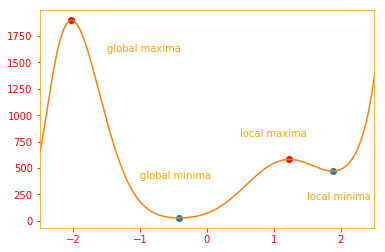

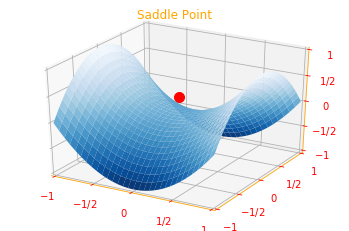

In [ ]:
"""
Let's see how these look like by plotting these. Note that I am using numpy for these plots but we will start 
using tensorflow in the upcoming sections. Also, taking the derivatives and most optimizations are 
easily done with packages like numpy, scipy or sympy since these are dedicated scientific libraries
whereas tensorflow is a machine learning framework but I am working on bringing a scientific extension to the 
tensorflow, please see (https://github.com/mukeshmithrakumar/scientific). 
This is work in progress and contributions are welcome.

"""

polynomial = np.poly1d([2,-4,-28,62,122,-256,-196,140,392,240,72])             # Create a one-dimensional polynomial class
polynomial_root = polynomial.deriv().r                                         # Return a derivative of this polynomial with the roots
r_crit = polynomial_root[polynomial_root.imag==0].real                         # Return the real part of the complex argument
test = polynomial.deriv(2)(r_crit) 

# local minima 
x_min = r_crit[test>0]
y_min = polynomial(x_min)
plt.plot(x_min, y_min, 'o')
plt.text(1.5, 200, 'local minima')

# local maxima 
x_max = r_crit[test<0]
y_max = polynomial(x_max)
plt.plot(x_max, y_max, 'o', color='r')
plt.text(0.5, 800, 'local maxima')

#global maxima
plt.text(-1.5, 1600, 'global maxima')

# global minima 
xc = np.arange(-2.5, 2.6, 0.02)
yc = polynomial(xc)
plt.plot( xc, yc)
plt.xlim([-2.5,2.5])
plt.text(-1, 400, 'global minima')


# Saddle Point
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plot_args = {'rstride': 1, 'cstride': 1, 'cmap':"Blues_r",
             'linewidth': 0.4, 'antialiased': True,
             'vmin': -1, 'vmax': 1}

x, y = np.mgrid[-1:1:31j, -1:1:31j]
z = x**2 - y**2
ax.plot_surface(x, y, z, **plot_args)
ax.view_init(azim=-60, elev=30)
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
plt.xticks([-1, -0.5, 0, 0.5, 1], [r"$-1$", r"$-1/2$", r"$0$", r"$1/2$", r"$1$"])
plt.yticks([-1, -0.5, 0, 0.5, 1],[r"$-1$", r"$-1/2$", r"$0$", r"$1/2$", r"$1$"])
ax.set_zticks([-1, -0.5, 0, 0.5, 1])
ax.set_zticklabels([r"$-1$", r"$-1/2$", r"$0$", r"$1/2$", r"$1$"])
ax.scatter([0], [0], [.3], s=100, color = 'r', marker="o")
plt.title("Saddle Point")
plt.show()

In deep learning we often deal with multidimensional inputs with functions that may have many local minima that are not optimal and many saddle points surrounded by very flat regions. This makes optimization difficult, we therefore usually settle for finding a value of $f$ that is very low but not necessarily minimal in any formal sense.

For functions with multiple inputs, we must make use of the concept of __partial derivatives__. The partial derivative $\frac{\partial}{\partial  x_i} f(x)$ measures how $f$ changes as only the variable $x_i$ increases at point __x__. The __gradient__ generalizes the notion of derivative to the case where the derivative is with respect to a vector: the gradient of $f$ is the vector containing all the partial derivatives, denoted $\nabla_x f(x)$. Element $i$ of the gradient is the partial derivative of $f$ with respect to $x_i$.

In [ ]:
"""
Lets say we have a function z = f(x, y) = 2x - y: The partial derivatives of this equation is:
dz_dx = 2, dz_dy = -1. Let's see how we can calculate this in tensorflow using GradientTape.

GradientTape records operations for automatic differentiation and we use it with persistent=True 
to allow multiple calls to the gradient(). Note that since we are using constants, we need to 
ensure that these are being traced when we do the GradientTape, hence we use a watch method.
But when we start working with variables, we don't need to have a watch.
"""

x = tf.constant(1.0)
y = tf.constant(2.0)

with tf.GradientTape(persistent=True) as g:
    g.watch(y)
    g.watch(x)
    out = tf.subtract(2*x, y)
dz_dx = g.gradient(out, x)
dz_dy = g.gradient(out, y)
del g  # Drop the reference to the tape

print("Partial Derivative of dz_dx: {} \nPartial Derivative of dz_dy: {} ".format(dz_dx, dz_dy))

Partial Derivative of dz_dx: 2.0 
Partial Derivative of dz_dy: -1.0 


The __directional derivative__ in direction $u$ (a unit vector) is the slope of the function $f$ in direction $u$. In other words, the directional derivative is the derivative of the function $f(x + \alpha u)$ with respect to $\alpha$, evaluated at $\alpha = 0$. Using the chain rule, we can see that $\frac{\partial}{\partial \alpha} f(x + \alpha u)$ evaluates to $u^{\top} \nabla_x f(x)$ when $\alpha = 0$.

To minimize $f$, we would like to find the direction in which $f$ decreases the fastest. We can do this using the directional derivative:

$$\color{orange}{min_{u, u^{\top} \ u=1} u^{\top} \nabla_x f(x) \tag{4}}$$

$$\color{orange}{=min_{u, u^{\top} \ u=1} \|u\|_2 \ \| \nabla_x f(x) \|_2 \ cos \theta  \tag{5}}$$

where $\theta$ is the angle between $u$ and the gradient. Substituting in $\|u\|_2 = 1$ and ignoring factors that do not depend on $u$, this simplifies to $min_u cos \theta$. This is minimized when $u$ points in the opposite direction as the gradient. in other words, the gradient points directly uphill, and the negative gradient points directly downhill. We can decrease $f$ by moving in the direction of the negative gradient. This is known as the __method of steepest descent__ or __gradient descent__.


Well, if you take away all the math, gradient descent simply states that if you move in the opposite direction of a functions gradient, you will be able to decrease it. Think about it this way, if you have climbed a mountain and you want to hike down, you know the fastest way down is from the way the mountain is steepest right. If you have skied, one of the fastest ways to reach the bottom is by skiing from the steepest parts. This is exactly what we do, we find the steepest part and then move in the opposite direction.


Steepest descent proposes a new point:

$$\color{orange}{x^{'} = x - \epsilon \nabla_x f(x) \tag{6}}$$

where $\epsilon$ is the __learning rate__, a positive scalar determining the size of the step.

Starting x value: 1.0
Iteration: 0 x: 0.6618226766586304
Iteration: 5 x: -0.38608598709106445
Iteration: 10 x: -0.691019594669342
Iteration: 15 x: -0.7591084241867065
Iteration: 20 x: -0.7734285593032837
Iteration: 25 x: -0.7764040231704712
Iteration: 30 x: -0.7770206928253174
Iteration: 35 x: -0.777148425579071
Iteration: 40 x: -0.7771748900413513


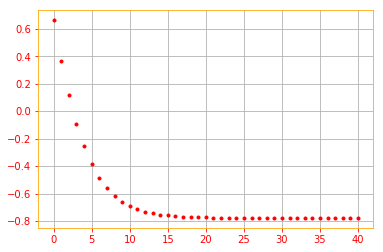

In [ ]:
"""
f(x,y) = x^2 + y^2 + xsiny + ysinx
f'(x, y) = (2 x + y cos(x) + sin(y)) dx + (2 y + x cos(y) + sin(x)) dy

If you know chain rule, this can be easily differentiated but if you don't, you don't have to worry, tensorflow
will take care of any kind of function for you using Gradient Tape

"""
def f(x, y):
    return tf.pow(x, 2) + tf.pow(y, 2) + tf.multiply(x, tf.math.sin(y)) + tf.multiply(y, tf.math.sin(x))

def grad(x, y):
    with tf.GradientTape() as t:
        t.watch(x)
        out = f(x, y)
    return t.gradient(out, x)


a = 0.1 # learning rate
x0 = tf.constant(1.0)
y0 = tf.constant(1.0) 
print("Starting x value: {}".format(x0))

update = []
for i in range(41):
    x0 -= a * grad(x0, y0)
    update.append(x0)
    plt.plot(i, update[-1], color='r', marker='.')
    if i%5 == 0:
        print("Iteration: {} x: {}".format(i, x0))
plt.grid()

Below is an animation of how our gradient takes small steps and finds the global minimum.

![Gradient descent with tensorflow](https://raw.githubusercontent.com/adhiraiyan/DeepLearningWithTF2.0/master/notebooks/figures/fig0403b.gif)

In some cases, we may be able to avoid running this iterative algorithm and just jump directly to the critical point by solving the equation $\nabla_x f(x) = 0$ for $x$.

Although gradient descent is limited to optimization in continuous spaces, the general concept of repeatedly making a small move (that is approximately the best small move) toward better configurations can be generalized to discrete spaces. Ascending an objective function of discrete parameters is called __hill climbing__.

Haha, I had to put this, the perfect analogy for gradient descent would be have you seen these videos where people roll down the hill, 

![Gradient descent example](https://raw.githubusercontent.com/adhiraiyan/DeepLearningWithTF2.0/master/notebooks/figures/fig0403c.jpg)

Gradient descent is exactly that, not everyone reaches the bottom (global minimum), they get stuck in pits (local minimum), where you start from the top (initial values) plays a huge part in the path you take and how fast you roll down (learning rate) determines how fast you reach the bottom and if you could potentially jump out of the pits. If you haven't watched these videos, take a look at [this](https://www.youtube.com/watch?v=fiaWyG7iKes) btw, that is just crazy.

## 4.3.1 Beyond the Gradient: Jacobian and Hessian Matrices

Suppose we need to find all the partial derivatives of a function whose input and output are both vectors. The matrix containing all such partial derivatives is known as a __Jacobian matrix__. Specifically, if we have a function $f : \mathbb{R}^m \rightarrow \mathbb{R}^n$, then the Jacobian matrix $J \in \mathbb{R}^{n \times m}$ of $f$ is defined such that $J_{i, j} = \frac{\partial}{\partial x_j} f(x)$.

In [ ]:
"""
Using Tensorflow GradientTape, we can easily find the Jacobian of any vector using "jacobian(target, sources)".
In this example for f(x) = x^2 we will look at the Jacobian when x = [1.0, 2.0]
"""

with tf.GradientTape() as g:
    x  = tf.constant([1.0, 2.0])
    g.watch(x)
    y = x * x
jacobian = g.jacobian(y, x)

print("Jacobian \n{}".format(jacobian))
del g  # Drop the reference to the tape

Jacobian 
[[2. 0.]
 [0. 4.]]


We are also sometimes interested in a derivative of a derivative. This is known
as a second derivative. For example, for a function  $f : \mathbb{R}^n \rightarrow \mathbb{R}$, the derivative with respect to $x_i$ of the derivative of $f$ with respect to $x_j$ is denoted as $\frac{\partial^2}{\partial x_i \partial x_j} f$. In a single dimension we denote $\frac{d^2}{dx^2} f$ by $f^{''}(x)$. The second derivative tells
us how the first derivative will change as we vary the input. This is important because it tells us whether a gradient step will cause as much of an improvement as we would expect based on the gradient alone. We can think of the second derivative as measuring __curvature__. 

In [ ]:
"""
We will use tf.GradientTape() to calculate the second derivative of the function 
f(x) = x^3
f'(x) = 3x^2
f''(x) = 6x
"""

x = tf.Variable(1.0)

with tf.GradientTape() as t:
    with tf.GradientTape() as t2:
        y = x * x * x
    dy_dx = t2.gradient(y, x)
d2y_dx2 = t.gradient(dy_dx, x)

print("First Derivative of f(x): {} \nSecond Derivative of f(x): {}".format(dy_dx, d2y_dx2))
del t, t2  # Drop the reference to the tape

First Derivative of f(x): 3.0 
Second Derivative of f(x): 6.0


Below is a plot of our function f(x) = x^3, f'(x) = 3x^2 and f''(x)=6x:

![First and second derivative plot](https://raw.githubusercontent.com/adhiraiyan/DeepLearningWithTF2.0/master/notebooks/figures/fig0403d.png)


The second derivative can be used to determine whether a critical point is
a local maximum, a local minimum, or a saddle point. 

- When $f^{'}(x) = 0$ and $f^{''}(x) > 0$, we can conclude that $x$ is a local minimum.

- When $f^{'}(x) = 0$ and $f^{''}(x) < 0$, we can conclude that $x$ is a local maximum.

- If $f^{''}(x) = 0$ then $x$ may be a saddle point or a part of a flat region.


- If the second derivative is zero, then there is no curvature. It is a perfectly flat line, and its value can be predicted using only the gradient. If the gradient is 1, then we can make a step of size $\epsilon$ along the negative gradient, and the cost function will decrease by $\epsilon$. 


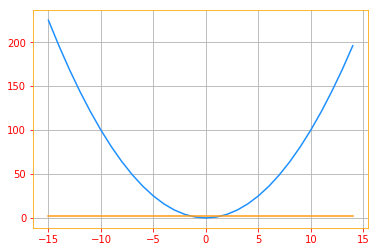

In [ ]:
# Plot where second derivative is zero

x0 = tf.range(-15., 15., 1.)
x = tf.Variable(x0)

def f(x): 
    return tf.pow(x, 2)

def second_derivative(x):
    """
    Note here since x is a variable we are not calling the watch method. 
    Since we are taking the second derivative, we need to call the GradientTape twice and use the 
    gradient() method to obtain the gradients.
    """
    with tf.GradientTape() as t:
        with tf.GradientTape() as t2:
            out = f(x)
        dy_dx = t2.gradient(out, x)
    d2y_dx2 = t.gradient(dy_dx, x)
    return d2y_dx2

# Original Function f(x) = x^2
plt.plot(x0, f(x0), color='dodgerblue')

# Second Derivative of f(x)
d2 = second_derivative(x)
plt.plot(x0, d2, color='#FF9A13')
plt.grid()


- If the second derivative is negative, the function curves downward, so the cost function will actually decrease by more than $\epsilon$.

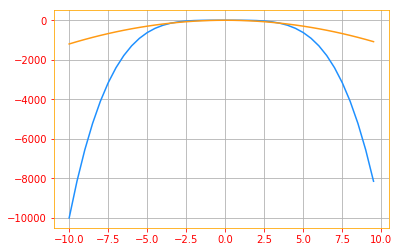

In [ ]:
# Plot where second derivative is negative

x0 = tf.range(-10., 10., .5)
x = tf.Variable(x0)

def f(x): 
    return -(tf.pow(x, 4))

def second_derivative(x):
    with tf.GradientTape() as t:
        with tf.GradientTape() as t2:
            out = f(x)
        dy_dx = t2.gradient(out, x)
    d2y_dx2 = t.gradient(dy_dx, x)
    return d2y_dx2

# Original Function f(x): -x^4
plt.plot(x0, f(x0), color='dodgerblue')

# Second Derivative of f(x)
d3 = second_derivative(x)
plt.plot(x0, d3, color='#FF9A13')
plt.grid()

- If the second derivative is positive, the function curves upward, so the cost function can decrease by less than $\epsilon$.

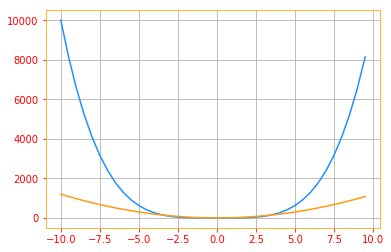

In [ ]:
# Plot where second derivative is positive

x0 = tf.range(-10., 10., .5)
x = tf.Variable(x0)

def f(x): 
    return (tf.pow(x, 4))

def second_derivative(x):
    with tf.GradientTape() as t:
        with tf.GradientTape() as t2:
            out = f(x)
        dy_dx = t2.gradient(out, x)
    d2y_dx2 = t.gradient(dy_dx, x)
    return d2y_dx2

# Original Function f(x): x^4
plt.plot(x0, f(x0), color='dodgerblue')

# Second Derivative of f(x)
d3 = second_derivative(x)
plt.plot(x0, d3, color='#FF9A13')
plt.grid()

When our function has multiple input dimensions, there are many second derivatives. These derivatives can be collected together into a matrix called the __Hessian matrix__. The Hessian matrix $H (f)(x)$ is defined such that:

$$\color{orange}{H(f)(x)_{i, j} = \frac{\partial^2}{\partial x_i \partial x_j} f(x) \tag{7}}$$

Equivalently, the Hessian is the Jacobian of the gradient. 

If you have been following everything upto now, this should make sense and if it does feel free to skip to the code, but sometimes it's better to recap, so let me explain what Hessian and Jacobian mean and how they are related, starting with the gradients in one dimension, a gradient is simply the slope of a function in a direction, if you have multiple direction (inputs), for each direction there is a different rate of change for each direction and gradient is simply a collection of all of this. Think of throwing a ball, the ball goes further (x direction) and higher (z direction) and if you take the derivative of the directions with respect to time, you get the individual velocities in each direction and the gradient is a matrix of such values. This matrix of gradients is called the Jacobian. Now, let's say you take the derivative of the velocities again, you end up with the acceleration of the ball in each direction (x and z) and this is the Hessian matrix, simple as that.

In [ ]:
"""
NOTE: As of 06.14.2019 tf.hessians doesn't work with tf eager mode and the tf.GradientTape doesn't
have a method hessians. There is a bug report open in GitHub 
(https://github.com/tensorflow/tensorflow/issues/29781) so as soon as that is resolved the following
code will work and I will fix this cell.

>>> f = 100*(y - x**2)**2 + (1 - x)**2
>>> x = tf.Variable([1., 1.])

>>> hessian_matrix = tf.hessians(f, x)
>>> print(hessian_matrix)

>>> with tf.GradientTape() as t:
... out = f
>>> hessian = t.hessians(out, x)

But for now, we will look into another way we can get the Hessian using the
equivalency of the Hessian being the gradient of the Jacobian for f(x,y)= x^3 - 2xy + y^6 and for 
points x = 1, y = 2, but note that this will return the sum of each column, the final 
Hessian Matrix will be:

[[ 6., -2.  ],
 [-2., -480.]]

I specifically took this example from Khan academy so if you want to see how the derivation is calculated, 
take a look at: 
(https://www.khanacademy.org/math/multivariable-calculus/applications-of-multivariable-derivatives/quadratic-approximations/a/the-hessian)

"""

def f(x): return tf.pow(x[0], 3) - 2*x[0]*x[1] - tf.pow(x[1], 6)


x = tf.Variable([1., 2.], dtype=tf.float32)

with tf.GradientTape() as h:
    with tf.GradientTape() as g:
        out = f(x)
    jacobian = g.jacobian(out, x)                      # Calls the Jacobian method
hessian = h.gradient(jacobian, x)                      # We take the gradient of the Jacobian to get the Hessian Matrix
    
print("Jacobian: \n{} \nHessian: \n{}".format(jacobian, hessian))

Jacobian: 
[  -1. -194.] 
Hessian: 
[   4. -482.]


Anywhere that the second partial derivatives are continuous, the differential
operators are commutative, this implies that:

$$\color{orange}{H_{i, j} = H_{j, i} \tag{8}}$$

so the Hessian matrix is symmetric at such points.

Most of the functions we encounter in the context of deep learning have a symmetric Hessian almost everywhere. Because the Hessian matrix is real and symmetric, we can decompose it into a set of real eigenvalues and an orthogonal basis of eigenvectors. If you don't recall Eigenvalues and Eigenvectors, I strongly suggest you review [Eigendecomposition](https://www.adhiraiyan.org/deeplearning/02.00-Linear-Algebra#7). But for the sake of completion, the eigenvectors of matrix M  are vectors that do not change direction when multiplied with M , and the eigenvalues represent the change in length of the eigenvector when multiplied with M .

The second derivative in a specific direction represented by a unit vector $d$ is given by $d^{\top} H d$. When $d$ is the eigenvector of $H$, the second derivative in that direction is given by the corresponding eigenvalue. For other directions of $d$, the directional second derivative is a weighted average of all the eigenvalues, with weights between 0 and 1, and eigenvectors that have a smaller angle with $d$ receiving more weight. The maximum eigenvalue determines the maximum second derivative, and the minimum eigenvalue determines the minimum second derivative. 

In [ ]:
# Eigenvalue and Eigenvectors for the Hessian matrix

hessian = tf.constant([[ 6., -2.], [-2., -480.]])
eigenvalues, eigenvectors = tf.linalg.eigh(hessian)

print("Eigenvalue for the Hessian: \n{} \n\nEigenvectors for the Hessian: \n{}".format(eigenvalues, eigenvectors))

Eigenvalue for the Hessian: 
[-480.00824    6.00823] 

Eigenvectors for the Hessian: 
[[ 0.00411512  0.99999154]
 [ 0.99999154 -0.00411512]]


The (directional) second derivative tells us how well we can expect a gradient
descent step to perform. We can make a second-order Taylor series approximation to the function $f(x)$ around the current point $x^{(0)}$ and if we use a learning rate of $\epsilon$, then the new point $x$ will be given by $x^{(0)} - \epsilon g$ which gives:

$$\color{orange}{f(x^{(0)} - \epsilon g) \approx f(x^{(0)}) - \epsilon g^{\top}g + \frac{1}{2} \epsilon^2 g^{\top} Hg \tag{9}}$$

I know, that looks complicated, let me explain. There are three terms here: the original value of the function, the expected improvement due to the slope of the function, and the correction we must apply to account for the curvature of the function. What you need to know is:

- When this last term is too large, the gradient descent step can actually move uphill.

- When it is zero or negative, the Taylor series approximation predicts that increasing $\epsilon$ forever will decrease $f$ forever.

Take a look at the image below. The graph on the left, which is the first derivative of a one dimensional function and the graph on the right is the second derivative of the same function.

![Hessian derivative directions](https://raw.githubusercontent.com/adhiraiyan/DeepLearningWithTF2.0/master/notebooks/figures/fig0403e.png)

In the left diagram, the slope changes a lot, while it is more stable in the right diagram. As you can see, the rate of change of the slope corresponds to how “curved” each loss function is. The sharper the curve, the more rapidly the slope changes.


In multiple dimensions, we need to examine all the second derivatives of the function. Using the eigendecomposition of the Hessian matrix, we can generalize the second derivative test to multiple dimensions. At a critical point, where $\nabla_x f(x) = 0$, we can examine the eigenvalues of the Hessian to determine whether the critical point is a local maximum, local minimum, or saddle point. 

- When the Hessian is positive definite (all its eigenvalues are positive), the point is a local minima.

- When the Hessian is negative definite (all its eigenvalues are negative), the point is a local maximum.

- When all the nonzero eigenvalues have the same sign but atleast one eigenvalue is zero, the derivative test can be inconclusive, like the univariate second derivative test.


In multiple dimensions, there is a different second derivative for each direction at a single point. The condition number of the Hessian at this point measures how much the second derivatives differ from each other. When the Hessian has a poor condition number, gradient descent performs poorly. This is because in one direction, the derivative increases rapidly, while in another direction, it increases slowly.  Gradient descent is unaware of this change in the derivative, so it does not know that it needs to explore preferentially in the direction where the derivative remains negative for longer. Poor condition number also makes choosing a good step size difficult. The step size must be small enough to avoid overshooting the minimum and going uphill in directions with strong positive curvature. This usually means that the step size is too small to make significant progress in other directions with less curvature. 

This issue can be resolved by using information from the Hessian matrix to guide the search. The simplest method for doing so is known as __Newton’s method__. Newton’s method is based on using a second-order Taylor series expansion to approximate $f(x)$ near some point $x^{(0)}$ and by solving for the critical point, we obtain:

$$\color{orange}{x^* = x^{(0)} - H(f)(x^{(0)})^{-1} \ \nabla_x f(x^{(0)}) \tag{10}}$$

- When $f$ is positive definite quadratic function, Newton's method consists of applying the above equation once to jump to the minimum of the function directly.

- When $f$ is not truly quadratic but can be locally approximated as a positive definite quadratic, Newton’s method consists of applying the above equation multiple times. 

Iteratively updating the approximation and jumping to the minimum of the approximation can reach the critical point much faster than gradient descent would. This is a useful property near a local minimum, but it can be a harmful property near a saddle point. 


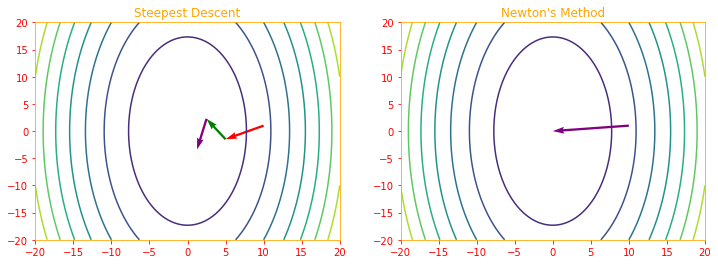

In [ ]:
"""
Let's see how Newton's method can be used to solve a quadratic function by applying it once.
We start with a quadratic function x^2 + 5y^2 and when you differentiate it, you end up with 2x + 10y
which would result in a Hessian of [[2 0], [0, 10]] because the derivative of 2x + 10y is 2 and 10.
"""

def quad(x):
    return ((x[1:])**2.0 + 5*(x[:-1])**2.0)

def quad_grad(x,y):
    return (tf.Variable([2.0*x, 10.0*y]))


# Create x and y values
x = tf.linspace(-20.0, 20.0, 100)
y = tf.linspace(-20.0, 20.0, 100)

# Broadcasts parameters for evaluation on an N-D grid
X, Y = tf.meshgrid(x, y)

# Reshape X and Y to pack along first dim (row wise) and apply the quadratic function and reshape it to get the original dimension
Z = tf.reshape(quad(tf.stack([tf.reshape(X, [10000,]), tf.reshape(Y, [10000,])], axis=0)), [100, 100])

# Take the inverse of the Hessian: (1/2, 1/10)
H_inv = - tf.constant([[0.5, 0], [0, 0.1]])

plt.figure(figsize=(12,4))
plt.subplot(121)

plt.contour(X,Y,Z);
plt.title("Steepest Descent");
step = -0.25
X0 = 10.0
Y0 = 1.0

# Here we calculate the Gradient of our function and take the dot product between the gradient and the Hessian inverse
N_grad = tf.tensordot(H_inv, quad_grad(X0,Y0), axes=1)

sgrad = step*quad_grad(X0,Y0)
plt.quiver(X0, Y0, sgrad[0], sgrad[1], color='red',angles='xy',scale_units='xy',scale=1);
X1 = X0 + sgrad[0]
Y1 = Y0 + sgrad[1]

sgrad = step*quad_grad(X1,Y1)
plt.quiver(X1.numpy(), Y1.numpy(), sgrad[0].numpy(), sgrad[1].numpy(), color='green', angles='xy', scale_units='xy', scale=1);
X2 = X1 + sgrad[0]
Y2 = Y1 + sgrad[1]

sgrad = step*quad_grad(X2,Y2)
plt.quiver(X2.numpy(), Y2.numpy(), sgrad[0].numpy(), sgrad[1].numpy(), color='purple',angles='xy',scale_units='xy',scale=1);


plt.subplot(122)
plt.contour(X,Y,Z);
plt.title("Newton's Method")
plt.quiver(X0, Y0, N_grad[0], N_grad[1], color='purple',angles='xy',scale_units='xy',scale=1);



Optimization algorithms that use only the gradient, such as gradient descent, are called __first-order optimization algorithms__. Optimization algorithms that also use the Hessian matrix, such as Newton’s method, are called __second-order optimization algorithms__.

Deep learning algorithms tend to lack guarantees because the family of functions used in deep learning is quite complicated. But sometimes we gain some guarantees by restricting ourselves to functions that are either __Lipschitz continuous__ or have Lipschitz continuous derivatives. A Lipschitz function is a function $f$ whose rate of change is bounded by a __Lipschitz constant__ $\mathcal{L}$:

$$\color{orange}{\forall x, \forall y, |f(x) - f(y)| \leq \mathcal{L} \| x - y \|_2 \tag{11}}$$

This property is useful because it enables us to quantify our assumption that a small change in the input made by an algorithm such as gradient descent will have a small change in the output. 

## 04.04 - Constrained Optimization

Sometimes we may wish to find the maximal or minimal value of $f(x)$ for values of $x$ in some set $\mathbb{S}$. This is knows as __constrained optimization__. Points that lie within the set $\mathbb{S}$ are called __feasible__ points in constrained optimization technology.

We often wish to find a solution that is small in some sense. A common approach in such situations is to impose a norm constraint, such as $\| x \| \leq 1$. One simple approach to constrained optimization is simply to modify gradient descent taking the constraint into account.


A more sophisticated approach is to design a different, unconstrained optimization problem whose solution can be converted into a solution to the original, constrained optimization problem. This approach requires creativity; the transformation between optimization problems must be designed specifically for each case we encounter.

The __Karush–Kuhn–Tucker (KKT)__ approach provides a very general
solution to constrained optimization. With the KKT approach, we introduce
a new function called the __generalized Lagrangian__ or __generalized Lagrange function__.

To define the Lagrangian, we first need to describe $\mathbb{S}$ in terms of equations and inequalities. We want a description of $\mathbb{S}$ in terms of m functions $g^{(i)}$ and $n$ functions $h^{(j)}$ so that $\mathbb{S} = \{ x \  \mid \ \forall i, g^{(i)} (x) = 0 \ \text{and} \ \forall j, h^{(j)} (x) \leq o) \}$. The equations involving $g^{(i)}$ are called __equality constraints__, and the inequalities involving $h^{(j)}$ are called __inequality constraints__.

We introduce new variables $\lambda_i$ and $\alpha_j$ for each constraint, these are called the KKT multipliers. The generalized Lagrangian is then defined as:

$$\color{orange}{L(x, \lambda, \alpha) = f(x) + \displaystyle\sum_i \lambda_i g^{(i)} (x) + \displaystyle\sum_j \alpha_j h^{(j)} (x) \tag{12}}$$

We can now solve a constrained minimization problem using unconstrained optimization of the generalized Lagrangian. As long as at least one feasible point exists and $f(x)$ is not permitted to have $\infty$.

[0, 3, 0, 3]

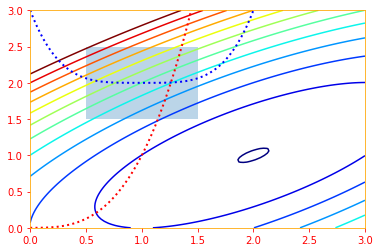

In [ ]:
"""
Let's see how this looks by plotting a function f(x) = −(2xy+2x−x^2−2y^2) with constraints 
x^3−y = 0 and y−(x−1)^4−2≥ 0 with bounds 0.5, 1.5, 1.5, 2.5. The solution will be where the
two constraints meet inside the bound.
"""

def f(x):
    return -(2*x[0]*x[1] + 2*x[0] - x[0]**2 - 2*x[1]**2)

x = np.linspace(0, 3, 100)
y = np.linspace(0, 3, 100)
X, Y = np.meshgrid(x, y)
Z = f(np.vstack([X.ravel(), Y.ravel()])).reshape((100,100))
plt.contour(X, Y, Z, np.arange(-1.99,10, 1), cmap='jet');
plt.plot(x, x**3, 'k:', linewidth=2, color='r')                   # constraint 1: x^3−y = 0
plt.plot(x, (x-1)**4+2, 'k:', linewidth=2, color='b')             # constraint 2: y−(x−1)^4−2≥ 0
plt.fill([0.5,0.5,1.5,1.5], [2.5,1.5,1.5,2.5], alpha=0.3)         # bounds 0.5, 1.5, 1.5, 2.5
plt.axis([0,3,0,3])

To perform constrained maximization, we can construct the generalized
Lagrange function of $- f(x)$, which leads to this optimization problem:

$$\color{orange}{min_x max_{\lambda} max_{\alpha, \alpha \geq 0} = - f(x) + \displaystyle\sum_i \lambda_i g^{(i)} (x) + \displaystyle\sum_j \alpha_j h^{(j)} (x) \tag{13}}$$

The sign of the term for the equality constraints does not matter; we may define it with addition or subtraction as we wish. 

A simple set of properties describe the optimal points of constrained optimization problems. These properties are called the Karush-Kuhn-Tucker (KKT) conditions. They are necessary conditions, but not always sufficient conditions, for a point to be optimal. The conditions are:

- The gradient of the generalized Lagrangian is zero.

- All constraints on both $x$ and the KKT multipliers are satisfied

- The inequality constraints exhibit "complementary slackness": $\alpha \odot h(x) = 0$

## 04.05 - Example: Linear Least Squares

Let's see how we can find the value of $x$ that minimizes:

$$\color{orange}{f(x) = \frac{1}{2} \| Ax - b \|_2^2 \tag{14}}$$

using gradient based optimization.

First we need to obtain the gradient:

$$\color{orange}{\nabla_x f(x) = A^{\top} (Ax - b) = A^{\top} Ax - A^{\top} b \tag{15}}$$

![Linear least squares](https://raw.githubusercontent.com/adhiraiyan/DeepLearningWithTF2.0/master/notebooks/figures/fig0405a.png)

One can also solve this problem using Newton’s method. In this case, because
the true function is quadratic, the quadratic approximation employed by Newton’s method is exact, and the algorithm converges to the global minimum in a single step.


slope (m): tf.Tensor(1.0040492, shape=(), dtype=float32)
intercept (b): tf.Tensor(0.011254057, shape=(), dtype=float32)


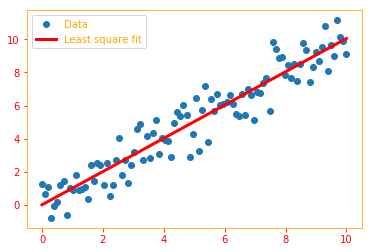

In [ ]:
"""
There are two ways to solve the above system. Direct method and iterative method.
We start with the iterative method. The optimal solution is where the gradient becomes zero
therefore it is at x = (A^T b)*(A^T A)^{-1} and this is what we will be calculating
"""

# Generate random x and y data
x_vals = np.linspace(0., 10., 100)
y_vals = x_vals + np.random.normal(loc=0, scale=1, size=100)

x_vals_column = np.transpose(np.matrix(x_vals))
ones_column = tf.ones([100, 1], dtype=tf.float32)

# tensorflow needs its data types in float so we cast the dtypes to float
A_tensor = tf.dtypes.cast(tf.concat([x_vals_column, ones_column], axis=1), tf.float32)
Y_tensor = tf.dtypes.cast(tf.reshape(tf.transpose(y_vals), [100, 1]), tf.float32)

# Iterative method
tA_A = tf.matmul(A_tensor, A_tensor, transpose_a=True)         # We calculate A^T A
tA_A_inv = tf.linalg.inv(tA_A)                                 # And take the inverse of it (A^TA)^{-1}
product = tf.matmul(tA_A_inv, A_tensor, transpose_b=True)      # Then multiply it with A to yield (A^TA)^{-1} A
A_eval = tf.matmul(product, Y_tensor)                          # Finally we find (A^TA)^{-1}*A*b


m_slope = A_eval[0][0]
b_intercept = A_eval[1][0]
print('slope (m): ' + str(m_slope))
print('intercept (b): ' + str(b_intercept))

# Now for each x_val we find the best fit line
best_fit = []
for i in x_vals:
    best_fit.append(m_slope * i + b_intercept)

plt.plot(x_vals, y_vals, 'o', label='Data')
plt.plot(x_vals, best_fit, 'r-', label='Least square fit', linewidth=3)
plt.legend(loc='upper left')
plt.show()

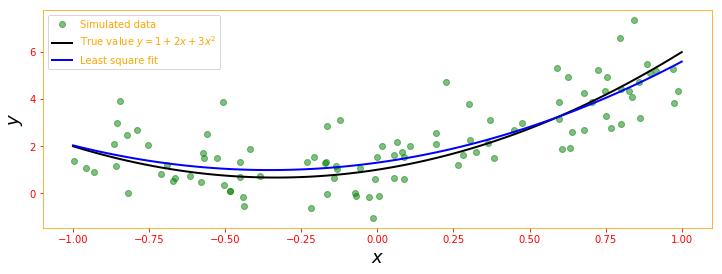

In [ ]:
"""
Next, we try the direct method for another dataset using tensorflows least squares class for function
f(x) = 1 + 2x + 3x^2
"""

# define true model parameters
x = np.linspace(-1, 1, 100)
a, b, c = 1, 2, 3
y_exact = a + b * x + c * x**2

# simulate noisy data points
m = 100
X = 1 - 2 * np.random.rand(m)
Y = tf.reshape(tf.convert_to_tensor(a + b * X + c * X**2 + np.random.randn(m)), [100, 1])
A = tf.stack([X**0, X**1, X**2], axis=1)

# Solving directly using tensorflow's least sqaures. 
sol = tf.linalg.lstsq(A, Y)

y_fit = sol[0] + sol[1] * x + sol[2] * x**2
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(X, Y, 'go', alpha=0.5, label='Simulated data')
ax.plot(x, y_exact, 'k', lw=2, label='True value $y = 1 + 2x + 3x^2$')
ax.plot(x, y_fit, 'b', lw=2, label='Least square fit')
ax.set_xlabel(r"$x$", fontsize=18)
ax.set_ylabel(r"$y$", fontsize=18)
ax.legend(loc=2);

Now, suppose we wish to minimize the same function, but subject to the constraint $x^{\top} x \leq 1$. To do so, we introduce the Lagrangian:

$$\color{orange}{L(x, \lambda) = f(x) + \lambda (x^{\top} x - 1) \tag{16}}$$

We can now solve the problem:

$$\color{orange}{min_x max_{\lambda, \lambda \geq 0} L(x, \lambda) \tag{17}}$$



In [ ]:
"""
Let' take an example: Maximize f(x,y,z)=xy+yz subject to the constraints x+2y=6 and x−3z=0.
We start by setting up the equation:

F(x,y,z,λ,α) = xy + yz − λ(x+2y−6) + α(x-3z)

Now set the partial derivatives to zero and solve the following set of equations:

y − λ − α = 0
x + z − 2λ = 0
y + 3α = 0
x + 2y −6 = 0
x − 3z = 0

which is a linear equation in  x,y,z,λ,μ, Now this can be put into the matrix equation:

[0, 1, 0, -1, -1] [x] = [0]
[1, 0, 1, -2,  0] [y] = [0]
[0, 1, 0,  0,  3] [z] = [0]
[1, 2, 0,  0,  0] [λ] = [6]
[1, 0,-3,  0,  0] [μ] = [0]

"""

matrix = tf.constant([
    [0, 1, 0, -1, -1],
    [1, 0, 1, -2, 0],
    [0, 1, 0, 0, 3],
    [1, 2, 0, 0, 0],
    [1, 0,-3, 0, 0]], dtype=tf.float32)

rhs = tf.constant([[0],[0],[0],[6],[0]], dtype=tf.float32)
solve = tf.linalg.solve(matrix, rhs)

print("Solving the constrained optimization using Lagrange multipliers yield x: \n{}".format(solve))

Solving the constrained optimization using Lagrange multipliers yield x: 
[[ 3. ]
 [ 1.5]
 [ 1. ]
 [ 2. ]
 [-0.5]]


The smallest norm solution to the unconstrained least squares problem may be found using the Moore-Penrose pseudoinverse: $x = A^+ b$. If this point is feasible, then it is the solution to the constrained problem.

In [ ]:
# Moore-penrose pseudoinverse solution to the above problem
mpp_solution = tfp.math.pinv(matrix)

print(mpp_solution)

tf.Tensor(
[[-0.75        0.375      -0.24999987  0.4999999   0.12500001]
 [ 0.37500003 -0.1875      0.12499993  0.25000003 -0.06250007]
 [-0.24999996  0.12499999 -0.08333326  0.1666666  -0.29166666]
 [-0.5        -0.2500001  -0.16666664  0.33333343 -0.08333337]
 [-0.12499999  0.06250004  0.29166666 -0.08333335  0.02083335]], shape=(5, 5), dtype=float32)


If the Moore-Penrose pseudoinverse solution is not feasible, we find the solution where the constraint is active by differetiating the Lagrangian with respect to $x$ and solving for $x$, we obtain:

$$\color{orange}{x = (A^{\top} A + 2 \lambda I)^{-1} A^{\top} b \tag{18}}$$

We can then find the magnitude of $\lambda$ by performing gradient ascent using:

$$\color{orange}{\frac{\partial}{\partial \lambda} L(x, \lambda) = x^{\top} x - 1 \tag{19}}$$

When the norm of $x$ exceeds 1, this derivative is positive, so to follow the derivative uphill and increase the Lagrangian with respect to $\lambda$, we increase $\lambda$. Because the coefficient on the $x^{\top} x$ penatly has increased, solving the linear equation for $x$ will now yield a solution with a smaller norm. The process of solving the linear equation and adjusting $\lambda$ continues until $x$ has the correct norm and the derivative on $\lambda$ is 0.



## 💫 Congratulations

You have successfully completed Chapter 4 Numerical Computation of [Deep Learning with Tensorflow 2.0](https://www.adhiraiyan.org/DeepLearningWithTensorflow.html). To recap, we went through the following concepts:

- Numerical Computation
- Overflow and Underflow
- Poor Conditioning
- Gradient Based Optimization
- Constrained Optimization
- Example: Linear Least Squares


If you like to read more about Numerical Computation take a look at [Numerical Methods
for Engineers by Steven C. Chapra](http://mechfamilyhu.net/download/uploads/mech144232415981.pdf) or [Numerical Methods for
Computational Science and Engineering by Prof. R. Hiptmair](http://www.sam.math.ethz.ch/~hiptmair/tmp/NumCSE/NumCSE15.pdf). 

This concludes the mathematical preliminaries that we use to develop machine learning algorithms. We are now ready to build and analyze some full-fledged machine learning systems. I am excited, are you 😍.

<!--NAVIGATION-->
< [03.00 - Probability and Information Theory](03.00-Probability-and-Information-Theory.ipynb) | [Contents](Index.ipynb) |

<a href="https://colab.research.google.com/github/adhiraiyan/DeepLearningWithTF2.0/blob/master/notebooks/04.00-Numerical-Computation.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


# **Differential Calculus**

Most if this part is from [here](https://github.com/xavierbourretsicotte/Data-Portfolio/blob/master/Intro_to_Optimization_Visualizations.ipynb) and [here](https://xavierbourretsicotte.github.io/Intro_optimization.html#Finding-extrema-of-a-function)

The following is a collection of sources of interest which were used to build this notebook:
- [Duke university: Optimization and Non-linear Methods][1]
- [Sebastien Ruder's blog][2]
- [Nonlinear Optimization course at the University of Jyväskylä][3]
- [Numerical python tours][4]
- [Louis Tiao's blog: visualizing-and-animating-optimization-algorithms-with-matplotlib][5]

[1]: https://people.duke.edu/~ccc14/sta-663/OptimizationInOneDimension.html
[2]: http://ruder.io/optimizing-gradient-descent/
[3]: https://github.com/maeehart/TIES483
[4]: http://www.numerical-tours.com/python/
[5]: http://tiao.io/notes/visualizing-and-animating-optimization-algorithms-with-matplotlib/


## **Finding roots of non linear functions (1D)**

**Example used throughout this section:**

Consider the following polynomial function which is continuous, differentiable and well behaved. It is an interesting example to use when testing root finding algorithms because it exhibits several *basins of attractions* in 1D. A basin of attraction is a set of initial values leading to the same solution (i.e. root in this case), see [here][1] for some details. In this example, different starting points will lead to different solutions, or in some cases no solutions at all when the algorithm "blows up"

The next section will investigate different methods of finding the **roots** of:

$f(x) = x^3 - 2x^2 - 11x + 12$

$f'(x) = 3x^2 - 4x - 11$

[1]: https://fr.mathworks.com/help/gads/what-is-global-optimization.html#bsbalkx-1

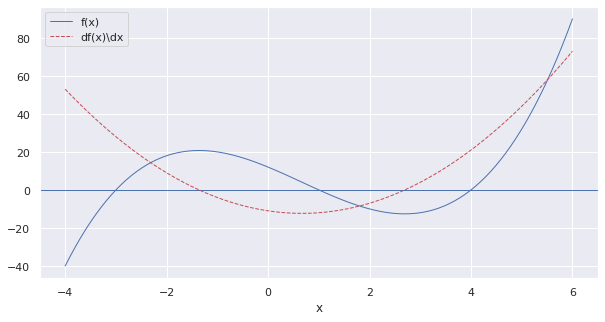

In [ ]:
import seaborn as sns

sns.set(rc={'figure.figsize':(10, 5), "lines.linewidth": 1.0})

#Defining the functions and its first derivative
def f(x):
    return x**3 - 2*x**2 - 11*x + 12

def dfdx(x):
    return 3*x**2 - 4*x - 11
    
#Initializing data
x = np.linspace(-4,6,100)
y = f(x)
y_dash = dfdx(x)

#Plotting the function and its derivative
#fig = plt.figure()
plt.xlabel('x')
plt.axhline(0)
plt.plot(x,y, label = 'f(x)')
plt.plot(x,y_dash, '--r', label = 'df(x)\dx')
plt.legend()
plt.show()

### **Bisection Method**

The bisection method is one of the simplest methods for finding zeroes of a non-linear function. It is guaranteed to find a root - but it can be slow. The main idea comes from the intermediate value theorem: If $f(a)$ and $f(b)$ have different signs and $f$ is continous, then f must have a zero between a and b. We evaluate the function at the midpoint, $c=\frac{1}{2}(a+b).$ $f(c)$ is either zero, has the same sign as f(a) or the same sign as $f(b)$. Suppose $f(c)$ has the same sign as f(a) (as pictured below). We then repeat the process on the interval $[c,b]$.

In [ ]:
def Bisection_Search(func,a,b,epsilon,nMax = 1000):
    #Initializating variables, iter_x, iter_x are used to plot results
    i = 0
    iter_x, iter_y, iter_count = np.empty(0),np.empty(0),np.empty(0)
    
    #Looping condition to ensure that loop is not infinite
    while i < nMax:
        i +=1
        c = .5 *(a + b)
        
        iter_x = np.append(iter_x,c)
        iter_y = np.append(iter_y,func(c))
        iter_count = np.append(iter_count ,i)
        
        if np.abs(func(c)) < epsilon:
            return c, iter_x, iter_y, iter_count
        elif np.sign(func(c)) == np.sign(func(a)): 
            a = c
        elif np.sign(func(c)) == np.sign(func(b)): 
            b = c

root,iter_x,iter_y, iter_count = Bisection_Search(f,-5,-2,0.01)

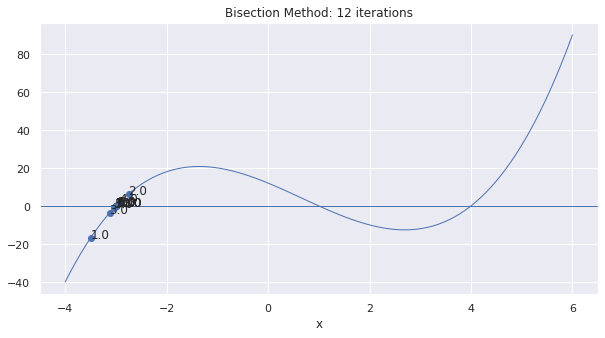

In [ ]:
#Plotting the iterations and intermediate values
fig, ax = plt.subplots() 
ax.set_xlabel('x')
ax.axhline(0)
ax.plot(x,y)
ax.scatter(x = iter_x,y = iter_y)
ax.set_title('Bisection Method: {} iterations'.format(len(iter_count)))

#Loop to add text annotations to the iteration points
for i, txt in enumerate(iter_count):
    ax.annotate(txt, (iter_x[i], iter_y[i]))
    
plt.show()

### **Newton (Raphson's) Method**

Newton's method, also known as Newton-Raphson's method, is a very famous and widely used method for solving nonlinear algebraic equations. Compared to the other methods we will consider, it is generally the fastest one (usually by far). It does not guarantee that an existing solution will be found, however.

Newton's method is normally formulated with an iteration index n: 

$x_{n+1} = x_n - \large \frac{f(x_n)}{f'(x_n)}$

To avoid storing intermediate values in memory, one can overwrite the previous value and work with a single variable: 

$x := x - \frac{f(x)}{f'(x)}$

In this example:

$f(x) = x^3 - 2x^2 - 11x + 12$

$f'(x) = 3x^2 - 4x - 11$


In [ ]:
def Newton_Raphson(func, deriv, x, epsilon, nMax = 100):
    #Initializating variables, iter_x, iter_x are used to plot results
    i = 0
    iter_x, iter_y, iter_count = np.empty(0),np.empty(0),np.empty(0)
    
    error = x - (x - func(x)/ deriv(x))
    
    #Looping as long as error is greater than epsilon
    while np.abs(error) > epsilon and i < nMax:
        i +=1
        iter_x = np.append(iter_x,x)
        iter_y = np.append(iter_y,func(x))
        iter_count = np.append(iter_count ,i)

        error = x - (x - func(x)/ deriv(x))
        x = x - func(x)/ deriv(x)
    
    
    return x, iter_x, iter_y, iter_count


root,iter_x,iter_y, iter_count = Newton_Raphson(f,dfdx,-2,0.01)

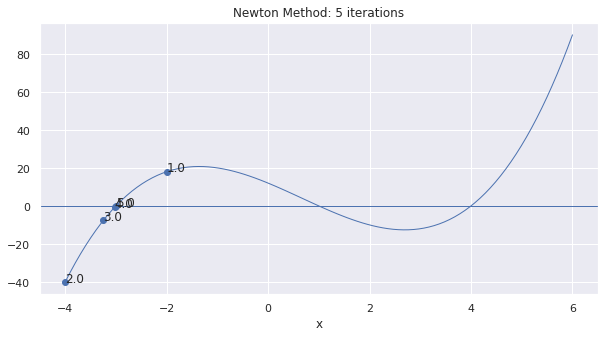

In [ ]:
#Plotting the iterations and intermediate values
fig, ax = plt.subplots() 
ax.set_xlabel('x')
ax.axhline(0)
ax.plot(x,y)
ax.scatter(x = iter_x,y = iter_y)
ax.set_title('Newton Method: {} iterations'.format(len(iter_count)))

for i, txt in enumerate(iter_count):
    ax.annotate(txt, (iter_x[i], iter_y[i]))
    
plt.show()

In [ ]:
# Newton Raphson's using Scipy
# Similar results are obtained using Scipy's built in optimizer

import scipy.optimize
scipy.optimize.newton(f,6,dfdx)

4.0

### **Secant method**

When finding the derivative $f′(x)$ in Newton's method is problematic, or when function evaluations take too long; we may adjust the method slightly. Instead of using tangent lines to the graph we may use secants. The approach is referred to as the secant method. 

The idea of the secant method is to think as in Newton's method, but instead of using $f′(x_n)$, we approximate this derivative by a finite difference or the secant, i.e., the slope of the straight line that goes through the two most recent approximations $x_n$ and $x_n{−1}$. This slope reads

$f'(x_n) \approx \large \frac{f(x_n) - f(x_{n-1})}{x_n - x_{n-1}}$

Inserting this expression for $f'(x_n)$ into Newton's method simply gives us the secant method:

$x_{n+1} = x_n - f(x_n) \times \large \frac{x_n - x_{n-1}}{f(x_n) - f(x_{n-1})}$

As with the Bisection Search - the secant method requires *two* starting points

In [ ]:
def Secant_method(func, x0,x1, epsilon, nMax = 100):
    #Initialization
    i = 0
    x2 = 0
    iter_x, iter_y, iter_count = np.empty(0),np.empty(0),np.empty(0)
    error = 100
    
    x2 = x1 - func(x1) * ((x1 - x0 ) / (func(x1) - func(x0))) 
    
    #Looping as long as error is greater than epsilon
    while np.abs(error) > epsilon and i < nMax:
        
        #Variables for plotting
        i +=1  
        iter_x = np.append(iter_x,x2)
        iter_y = np.append(iter_y,func(x2))
        iter_count = np.append(iter_count ,i)
        
        # Calculate new value
        x2 = x1 - func(x1) * ((x1 - x0 ) / (func(x1) - func(x0))) 
        error = x2 - x1
        x0 = x1
        x1 = x2
   
    return x2, iter_x, iter_y, iter_count


root,iter_x,iter_y, iter_count = Secant_method(f,-5,-2,0.01)

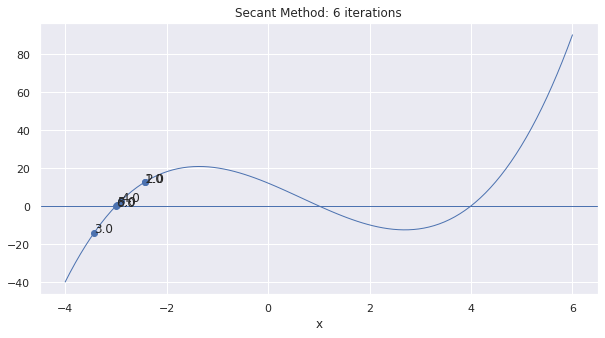

In [ ]:
#Plotting the iterations and intermediate values
fig, ax = plt.subplots() 
ax.set_xlabel('x')
ax.axhline(0)
ax.plot(x,y)
ax.scatter(x = iter_x,y = iter_y)
ax.set_title('Secant Method: {} iterations'.format(len(iter_count)))

for i, txt in enumerate(iter_count):
    ax.annotate(txt, (iter_x[i], iter_y[i]))
    
plt.show()

## **Finding extrema of a function**

In this section, we are concerned in *optimizing* a function rather than finding a root, or solution. As a result the algorithms will try to find local / global minimum and maximum points. A well known function used to compare optimization algorithms is the Rosenbrock function, described next.

**Introducing the [Rosenbrock function]** [1]

In mathematical optimization, the Rosenbrock function is a non-convex function, introduced by Howard H. Rosenbrock in 1960, which is used as a performance test problem for optimization algorithms. It is also known as Rosenbrock's valley or Rosenbrock's banana function.

The global minimum is inside a long, narrow, parabolic shaped flat valley. To find the valley is trivial. To converge to the global minimum, however, is difficult.

**The function is defined by:**

$f(x,y) = (a - x)^2 + b(y - x^2)^2$ and has a global minimum at $(x,y) = (a,a^2)$. Usually we choose parameters $(a,b) = (1, 100)$ giving: 

$f(x,y) = (1 - x)^2 + 100(y - x^2)^2$ with minimum at $(1,1)$

**Gradient**

$\nabla f = [-400xy + 400x^3 + 2x -2, 200y - 200x^2]$

**Hessian**

$H = \begin{bmatrix}-400y + 1200x^2 + 2 & -400x \\ -400x & 200 \end{bmatrix} $

[1]: https://en.wikipedia.org/wiki/Rosenbrock_function

In [ ]:
def Rosenbrock(x,y):
    return (1 + x)**2 + 100*(y - x**2)**2

def Grad_Rosenbrock(x,y):
    g1 = -400*x*y + 400*x**3 + 2*x -2
    g2 = 200*y -200*x**2
    return np.array([g1,g2])

def Hessian_Rosenbrock(x,y):
    h11 = -400*y + 1200*x**2 + 2
    h12 = -400 * x
    h21 = -400 * x
    h22 = 200
    return np.array([[h11,h12],[h21,h22]])
    
    

**Gradient descent method**

Gradient descent (or steepest descent) is a first-order iterative optimization algorithm for finding the minimum of a function. To find a local minimum of a function using gradient descent, one takes steps proportional to the negative of the gradient (or approximate gradient) of the function at the current point. If instead one takes steps proportional to the positive of the gradient, one approaches a local maximum of that function; the procedure is then known as gradient ascent.

The approach is based on the observation that if a multivariable function is defined and differentiable in a neighborhood of a point, then the function decreases fastest in the direction of the negative gradient. It follows that if: 

$\mathbf{x_{n+1} = x_n} - \gamma \nabla \mathbf{F(x)}$

For $\gamma$ small enough, then $F(x_n) \geq F(x_{n+1})$

The value of $\gamma$ is called the stepsize and is allowed to change at every iteration. Some more advanced implementations find the optimal value of $gamma$ at each step by using line search methods...

**Comments**
- The gradient is everywhere perpendicular to the contour lines.
- After each line minimization the new gradient is always orthogonal to the previous step direction (true of any line minimization.)
- Consequently, the iterates tend to zig-zag down the valley in a very
inefficient manner

**Gradient Descent implementation**

In [ ]:
def Gradient_Descent(Grad,x,y, gamma = 0.00125, epsilon=0.0001, nMax = 10000 ):
    #Initialization
    i = 0
    iter_x, iter_y, iter_count = np.empty(0),np.empty(0), np.empty(0)
    error = 10
    X = np.array([x,y])
    
    #Looping as long as error is greater than epsilon
    while np.linalg.norm(error) > epsilon and i < nMax:
        i +=1
        iter_x = np.append(iter_x,x)
        iter_y = np.append(iter_y,y)
        iter_count = np.append(iter_count ,i)   
        #print(X) 
        
        X_prev = X
        X = X - gamma * Grad(x,y)
        error = X - X_prev
        x,y = X[0], X[1]
          
    print(X)
    return X, iter_x,iter_y, iter_count


root,iter_x,iter_y, iter_count = Gradient_Descent(Grad_Rosenbrock,-2,2)

[0.91654302 0.83970004]


**Plotting the Rosenbrock function and the Gradient Descent iteration steps**

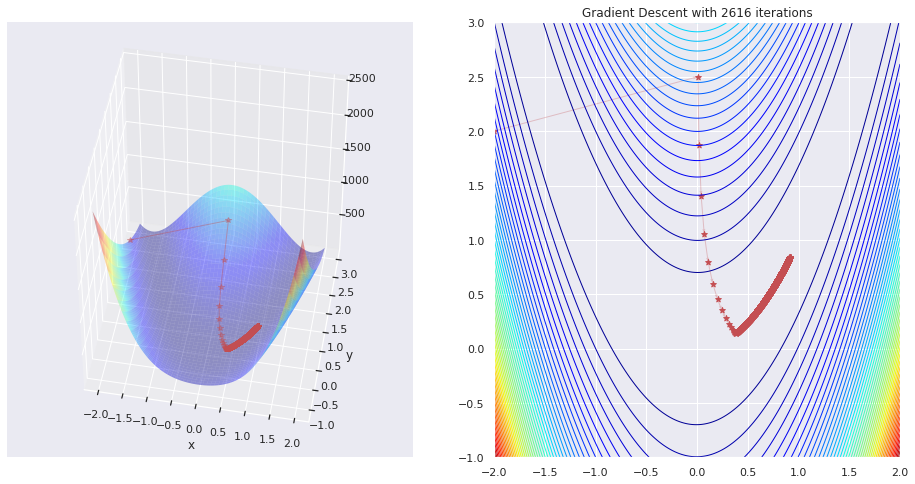

In [ ]:
x = np.linspace(-2,2,250)
y = np.linspace(-1,3,250)
X, Y = np.meshgrid(x, y)
Z = Rosenbrock(X, Y)

#Angles needed for quiver plot
anglesx = iter_x[1:] - iter_x[:-1]
anglesy = iter_y[1:] - iter_y[:-1]


%matplotlib inline
fig = plt.figure(figsize = (16,8))

#Surface plot
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(X,Y,Z,rstride = 5, cstride = 5, cmap = 'jet', alpha = .4, edgecolor = 'none' )
ax.plot(iter_x,iter_y, Rosenbrock(iter_x,iter_y),color = 'r', marker = '*', alpha = .4)

ax.view_init(45, 280)
ax.set_xlabel('x')
ax.set_ylabel('y')


#Contour plot
ax = fig.add_subplot(1, 2, 2)
ax.contour(X,Y,Z, 50, cmap = 'jet')
#Plotting the iterations and intermediate values
ax.scatter(iter_x,iter_y,color = 'r', marker = '*')
ax.quiver(iter_x[:-1], iter_y[:-1], anglesx, anglesy, scale_units = 'xy', angles = 'xy', scale = 1, color = 'r', alpha = .3)
ax.set_title('Gradient Descent with {} iterations'.format(len(iter_count)))


plt.show()

**Comments**

As expected, the algorithm finds the "valley" - however it struggles to reach the global minimum and gets stuck in a zigzag behaviour. Even after several thousand iterations, the minimum is not found. Trying different initial values leads to vastly different results, many of which are not close to the global minimum, and in many cases leading to infinite values (i.e. algorithm does not converge)

The behaviour is also very dependent on the initial choice of the $\gamma$ value. 

**Gradient descent on a simpler function (quadratic)**

Consider a simpler function to optimize. 

$f(x,y) = .01x^2 + .1y^2$

As this function is convex and significantly easier to optimize, we would expect the Gradient Descent algorithm to give better results than for the Rosenbrock function. 

In [ ]:
def f(x,y):
    return .01*x**2 + .1*y**2

def Grad_f(x,y):
    g1 = 2*.01*x
    g2 = 2*.1*y
    return np.array([g1,g2]) 

root,iter_x,iter_y, iter_count = Gradient_Descent(Grad_f,-2,-2,1)

[-4.85736291e-03 -2.64147266e-29]


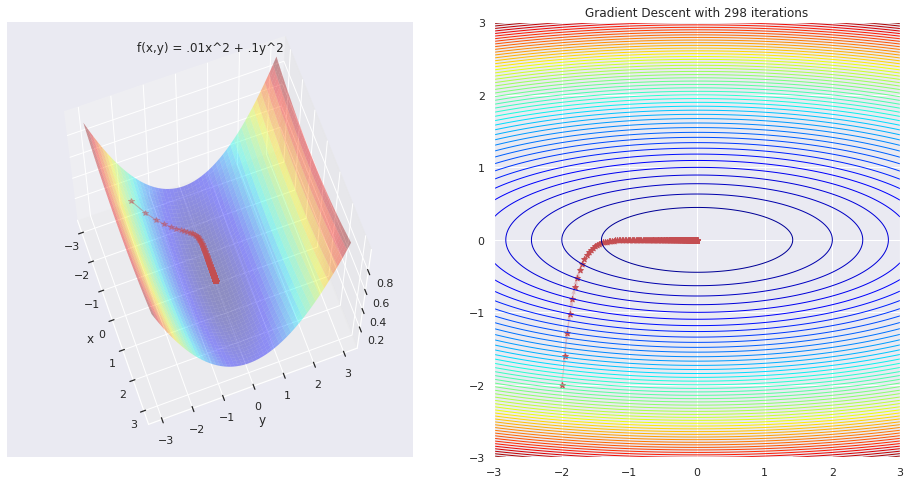

In [ ]:
x = np.linspace(-3,3,250)
y = np.linspace(-3,3,250)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

#Angles needed for quiver plot
anglesx = iter_x[1:] - iter_x[:-1]
anglesy = iter_y[1:] - iter_y[:-1]


%matplotlib inline
fig = plt.figure(figsize = (16,8))

#Surface plot
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(X,Y,Z,rstride = 5, cstride = 5, cmap = 'jet', alpha = .4, edgecolor = 'none' )
ax.plot(iter_x,iter_y, f(iter_x,iter_y),color = 'r', marker = '*', alpha = .4)
ax.set_title('f(x,y) = .01x^2 + .1y^2')


ax.view_init(65, 340)
ax.set_xlabel('x')
ax.set_ylabel('y')


#Contour plot
ax = fig.add_subplot(1, 2, 2)
ax.contour(X,Y,Z, 50, cmap = 'jet')
#Plotting the iterations and intermediate values
ax.scatter(iter_x,iter_y,color = 'r', marker = '*')
ax.quiver(iter_x[:-1], iter_y[:-1], anglesx, anglesy, scale_units = 'xy', angles = 'xy', scale = 1, color = 'r', alpha = .3)
ax.set_title('Gradient Descent with {} iterations'.format(len(iter_count)))

plt.show()

**Newton's method**

Similarly to the root finding algorithm, Newton's method for finding extrema takes the form:

$x_{n+1} = x_n - \frac{f'(x_n)}{f''(x_n)}$

Extending to multivariate case, we replace the derivative with the gradient $\nabla f(x_n)$ and the reciprocal of the second derivative with the inverse of the Hessian matrix:

$x_{n+1} = x_n - [\mathbf{H} \ f(x_n)]^{-1} \nabla f(x_n)$

Finding the inverse of the Hessian in high dimensions can be computationally expensive. In such cases, instead of inverting the Hessian it is better to calculate the vector $\delta x = x_{n+1} - x_n$ as the solution to the linear system of equations:

$[\mathbf{H} \ f(x_n)] \nabla \mathbf{x_n} = - \nabla f(x_n)$

Note that since Newton's method converges quadratically, any (smooth) quadratic function will be optimized in one step, as is shown in the trivial example below.

**Example 1) Simple case**

$f(x_1, x_2) = 0.5 x_1^2 + 2.5x_2^2$ where $\mathbf{x} = \begin{bmatrix}x_1 \\ x_2 \end{bmatrix}$

$\nabla \ f(x_1,x_2) = \begin{bmatrix}x_1 \\ 5x_2 \end{bmatrix} $ and $H = J(\nabla^T) = \begin{bmatrix} 1 & 0 \\ 0 & 5 \end{bmatrix} $

$H^{-1} = \begin{bmatrix}1 & 0 \\ 0 & 1/5 \end{bmatrix}$

$\mathbf{x_{n+1} = x_n - H^{-1}_n} \nabla f(\mathbf{x_n})$ 

$\begin{bmatrix}x_1\\ x_2 \end{bmatrix}_{n+1} := \begin{bmatrix}x_1\\ x_2 \end{bmatrix}_{n} -  \begin{bmatrix}1 & 0 \\ 0 & 1/5 \end{bmatrix}  \begin{bmatrix}x_1 \\ 5x_2 \end{bmatrix}_n = \begin{bmatrix}x_1 \\ x_2 \end{bmatrix}_n - \begin{bmatrix}x_1 \\ x_2 \end{bmatrix}_n  = \begin{bmatrix}0 \\ 0 \end{bmatrix}$

In [ ]:
def Newton_Raphson_Optimize(Grad, Hess, x,y, epsilon=0.000001, nMax = 200):
    #Initialization
    i = 0
    iter_x, iter_y, iter_count = np.empty(0),np.empty(0), np.empty(0)
    error = 10
    X = np.array([x,y])
    
    #Looping as long as error is greater than epsilon
    while np.linalg.norm(error) > epsilon and i < nMax:
        i +=1
        iter_x = np.append(iter_x,x)
        iter_y = np.append(iter_y,y)
        iter_count = np.append(iter_count ,i)   
        print(X) 
        
        X_prev = X
        X = X - np.linalg.inv(Hess(x,y)) @ Grad(x,y)
        error = X - X_prev
        x,y = X[0], X[1]
          
    return X, iter_x,iter_y, iter_count


root,iter_x,iter_y, iter_count = Newton_Raphson_Optimize(Grad_Rosenbrock,Hessian_Rosenbrock,-2,2)

[-2  2]
[-1.9925187   3.97007481]
[ 0.96687269 -7.82315462]
[0.96689159 0.93487935]
[1.         0.99890383]
[1. 1.]


**Plotting the iterations on top of the surface and contour plot**

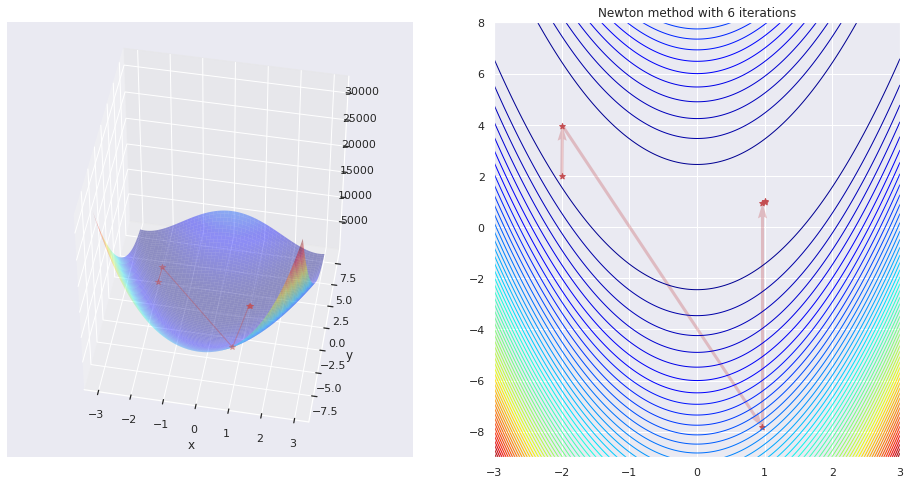

In [ ]:
x = np.linspace(-3,3,250)
y = np.linspace(-9,8,350)
X, Y = np.meshgrid(x, y)
Z = Rosenbrock(X, Y)

#Angles needed for quiver plot
anglesx = iter_x[1:] - iter_x[:-1]
anglesy = iter_y[1:] - iter_y[:-1]

%matplotlib inline
fig = plt.figure(figsize = (16,8))

#Surface plot
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(X,Y,Z,rstride = 5, cstride = 5, cmap = 'jet', alpha = .4, edgecolor = 'none' )
ax.plot(iter_x,iter_y, Rosenbrock(iter_x,iter_y),color = 'r', marker = '*', alpha = .4)

#Rotate the initialization to help viewing the graph
ax.view_init(45, 280)
ax.set_xlabel('x')
ax.set_ylabel('y')

#Contour plot
ax = fig.add_subplot(1, 2, 2)
ax.contour(X,Y,Z, 60, cmap = 'jet')
#Plotting the iterations and intermediate values
ax.scatter(iter_x,iter_y,color = 'r', marker = '*')
ax.quiver(iter_x[:-1], iter_y[:-1], anglesx, anglesy, scale_units = 'xy', angles = 'xy', scale = 1, color = 'r', alpha = .3)
ax.set_title('Newton method with {} iterations'.format(len(iter_count)))

plt.show()

**Comments**

The Newton Raphson method converges extremely rapidly to the global solution, despite the significant challenge posed by the Rosenbrock function. Irrespective of the starting point (within the scope of the graph above) the minimum is found within 4 - 6 iterations. Compare this to the several thousand iterations required by the gradient descent approach. 

**Newton Raphson optimization using Scipy**

In [ ]:
from scipy.optimize import minimize, rosen, rosen_der, rosen_hess
x0 = [-3,10]
res = minimize(rosen, x0, method='trust-exact', jac=rosen_der, hess = rosen_hess, tol = 1e-4, callback = print)

[-3.34156028 10.93985987]
[-3.24765428 10.53843996]
[-2.94123005  8.56205209]
[-2.73110304  7.41477048]
[-2.35156609  5.3858148 ]
[-2.23913388  5.00107952]
[-2.23913388  5.00107952]
[-2.12619562  4.51398375]
[-1.89449812  3.54119123]
[-1.62108086  2.55314617]
[-1.45676419  2.09516192]
[-1.45676419  2.09516192]
[-1.28489394  1.62555025]
[-1.28489394  1.62555025]
[-1.18377752  1.39665024]
[-0.9852495   0.93772951]
[-0.72394346  0.45581329]
[-0.60631767  0.35378529]
[-0.60631767  0.35378529]
[-0.43823373  0.16838839]
[-0.18732427 -0.02786518]
[-0.09996392  0.00236095]
[-0.09996392  0.00236095]
[ 0.02424149 -0.01383994]
[0.27536853 0.01276304]
[0.29259222 0.07926026]
[0.39861302 0.14551616]
[0.56224523 0.2893442 ]
[0.63112767 0.39357734]
[0.78422169 0.59121977]
[0.82170416 0.6737928 ]
[0.82170416 0.6737928 ]
[0.85384016 0.7273989 ]
[0.91640806 0.83561331]
[0.96188578 0.92315603]
[0.98884745 0.97709235]
[0.99858438 0.99707596]
[0.99997366 0.99994538]
[0.99999999 0.99999998]


**Comparing Newton and Gradient Descent in presence of a single saddle point**

$f_2(x,y) = .01x^2 - .1y^2$

$f'_2(x,y) = .02x - .2y$

In [ ]:
def f_2(x,y):
    return .01*x**2 - .1*y**2

def Grad_f_2(x,y):
    g1 = 2*.01*x
    g2 = - 2*.1*y
    return np.array([g1,g2])

def Hessian_f_2(x,y):
    return np.array([[.02,0],[0,-.2]]) 

[-1.50866182 -0.95396217]
[-2.   -0.01]
[0. 0.]


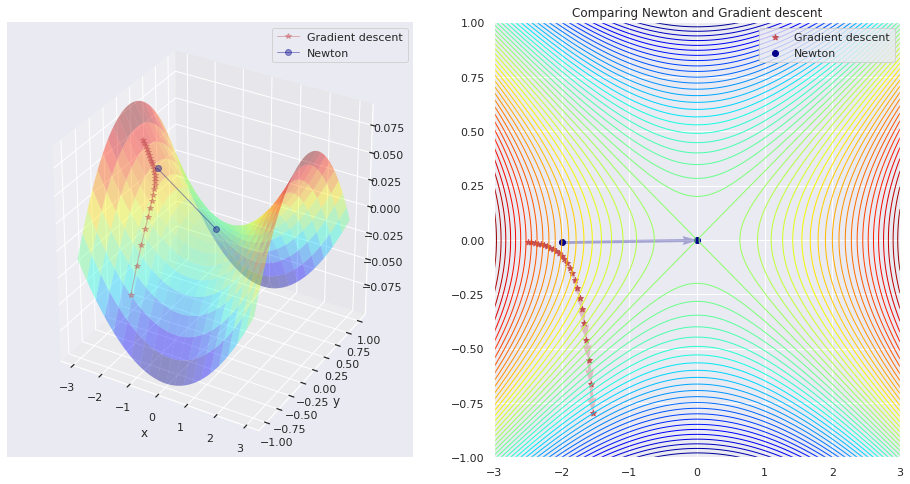

In [ ]:
root_gd,iter_x_gd,iter_y_gd, iter_count_gd = Gradient_Descent(Grad_f_2,-2.5,-0.010,1, nMax = 25)
root_nr,iter_x_nr,iter_y_nr, iter_count_nr = Newton_Raphson_Optimize(Grad_f_2,Hessian_f_2,-2,-.01, nMax = 25)

x = np.linspace(-3,3,100)
y = np.linspace(-1,1,100)
X, Y = np.meshgrid(x, y)
Z = f_2(X, Y)

#Angles needed for quiver plot
anglesx = iter_x_gd[1:] - iter_x_gd[:-1]
anglesy = iter_y_gd[1:] - iter_y_gd[:-1]
anglesx_nr = iter_x_nr[1:] - iter_x_nr[:-1]
anglesy_nr = iter_y_nr[1:] - iter_y_nr[:-1]

%matplotlib inline
fig = plt.figure(figsize = (16,8))

#Surface plot
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(X,Y,Z,rstride = 5, cstride = 5, cmap = 'jet', alpha = .4, edgecolor = 'none' )
ax.plot(iter_x_gd,iter_y_gd, f_2(iter_x_gd,iter_y_gd),color = 'r', marker = '*', alpha = .4, label = 'Gradient descent')
ax.plot(iter_x_nr,iter_y_nr, f_2(iter_x_nr,iter_y_nr),color = 'darkblue', marker = 'o', alpha = .4, label = 'Newton')
ax.legend()

#Rotate the initialization to help viewing the graph
#ax.view_init(45, 280)
ax.set_xlabel('x')
ax.set_ylabel('y')

#Contour plot
ax = fig.add_subplot(1, 2, 2)
ax.contour(X,Y,Z, 60, cmap = 'jet')
#Plotting the iterations and intermediate values
ax.scatter(iter_x_gd,iter_y_gd,color = 'r', marker = '*', label = 'Gradient descent')
ax.quiver(iter_x_gd[:-1], iter_y_gd[:-1], anglesx, anglesy, scale_units = 'xy', angles = 'xy', scale = 1, color = 'r', alpha = .3)
ax.scatter(iter_x_nr,iter_y_nr,color = 'darkblue', marker = 'o',  label = 'Newton')
ax.quiver(iter_x_nr[:-1], iter_y_nr[:-1], anglesx_nr, anglesy_nr, scale_units = 'xy', angles = 'xy', scale = 1, color = 'darkblue', alpha = .3)
ax.legend()

ax.set_title('Comparing Newton and Gradient descent')

plt.show()

**Comparing Newton and Gradient Descent in presence of a multiple saddle points**

[Using the himmelblau function][1]
$f(x,y)=(x^{2}+y-11)^{2}+(x+y^{2}-7)^{2}.\quad $

$\nabla f(x,y) = [2 (-7 + x + y^2 + 2 x (-11 + x^2 + y)), 2 (-11 + x^2 + y + 2 y (-7 + x + y^2))] $

$H f(x,y) = \begin{bmatrix} 4 (x^2 + y - 11) + 8 x^2 + 2 & 4 x + 4 y \\
4 x + 4 y & 4 (x + y^2 - 7) + 8 y^2 + 2) \end{bmatrix}$


[1]: https://en.wikipedia.org/wiki/Himmelblau%27s_function

In [ ]:
def Himmer(x,y):
    return (x**2 + y - 11)**2 + ( x + y**2 - 7 )**2

def Grad_Himmer(x,y):
    return np.array([2 * (-7 + x + y**2 + 2 * x * (-11 + x**2 + y)), 2 * (-11 + x**2 + y + 2 * y * (-7 + x + y**2))])

def Hessian_Himmer(x,y):
    h11 = 4 * (x**2 + y - 11) + 8 * x**2 + 2
    h12 = 4 * x + 4 * y
    h21 = 4 * x + 4 * y 
    h22 = 4 * (x + y**2 - 7) + 8 * y**2 + 2
    
    return np.array([[h11,h12],[h21,h22]]) 

In [ ]:
root_gd,iter_x_gd,iter_y_gd, iter_count_gd = Gradient_Descent(Grad_Himmer,0.5,-2,gamma = 0.001, epsilon=0.01, nMax = 1000)
#(Grad,x,y, gamma = 0.00125, epsilon=0.0001, nMax = 10000 )


[ 3.49508119 -1.77829953]


In [ ]:
root_nr,iter_x_nr,iter_y_nr, iter_count_nr = Newton_Raphson_Optimize(Grad_Himmer,Hessian_Himmer,0.5,-2, nMax = 50)

[ 0.5 -2. ]
[-0.15721649 -1.93513746]
[-0.1278321  -1.95412029]
[-0.12796132 -1.95371518]


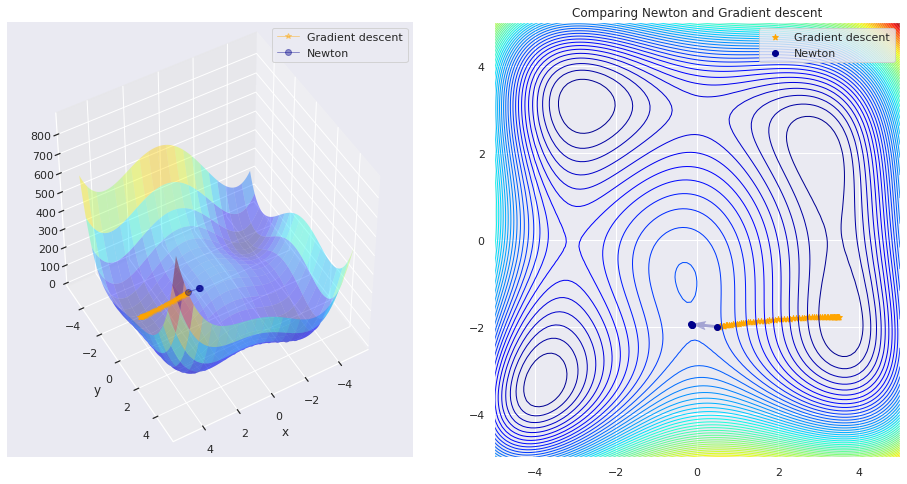

In [ ]:

x = np.linspace(-5,5,100)
y = np.linspace(-5,5,100)
X, Y = np.meshgrid(x, y)
Z = Himmer(X, Y)

#Angles needed for quiver plot
anglesx = iter_x_gd[1:] - iter_x_gd[:-1]
anglesy = iter_y_gd[1:] - iter_y_gd[:-1]
anglesx_nr = iter_x_nr[1:] - iter_x_nr[:-1]
anglesy_nr = iter_y_nr[1:] - iter_y_nr[:-1]

%matplotlib inline
fig = plt.figure(figsize = (16,8))

#Surface plot
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(X,Y,Z,rstride = 5, cstride = 5, cmap = 'jet', alpha = .4, edgecolor = 'none' )
ax.plot(iter_x_gd,iter_y_gd, f_2(iter_x_gd,iter_y_gd),color = 'orange', marker = '*', alpha = .4, label = 'Gradient descent')
ax.plot(iter_x_nr,iter_y_nr, f_2(iter_x_nr,iter_y_nr),color = 'darkblue', marker = 'o', alpha = .4, label = 'Newton')
ax.legend()

#Rotate the initialization to help viewing the graph
ax.view_init(45, 60)
ax.set_xlabel('x')
ax.set_ylabel('y')

#Contour plot
ax = fig.add_subplot(1, 2, 2)
ax.contour(X,Y,Z, 60, cmap = 'jet')

#Plotting the iterations and intermediate values
ax.scatter(iter_x_gd,iter_y_gd,color = 'orange', marker = '*', label = 'Gradient descent')
ax.quiver(iter_x_gd[:-1], iter_y_gd[:-1], anglesx, anglesy, scale_units = 'xy', angles = 'xy', scale = 1, color = 'orange', alpha = .3)
ax.scatter(iter_x_nr,iter_y_nr,color = 'darkblue', marker = 'o',  label = 'Newton')
ax.quiver(iter_x_nr[:-1], iter_y_nr[:-1], anglesx_nr, anglesy_nr, scale_units = 'xy', angles = 'xy', scale = 1, color = 'darkblue', alpha = .3)
ax.legend()

ax.set_title('Comparing Newton and Gradient descent')

plt.show()

**Drawbacks of Newton's method** 

A combination of two reasons: 

 - Newton method attracts to saddle points; 
 - [saddle points][1] are common in machine learning, or in fact any multivariable optimization.

Look at the function $$f=x^2-y^2$$
[![enter image description here][2]][2]

If you apply [multivariate Newton method][3], you get the following.
$$\mathbf{x}_{n+1} = \mathbf{x}_n - [\mathbf{H}f(\mathbf{x}_n)]^{-1} \nabla f(\mathbf{x}_n)$$

Let's get the [Hessian][4]:
$$\mathbf{H}= \begin{bmatrix}
  \dfrac{\partial^2 f}{\partial x_1^2} & \dfrac{\partial^2 f}{\partial x_1\,\partial x_2} & \cdots & \dfrac{\partial^2 f}{\partial x_1\,\partial x_n} \\[2.2ex]
  \dfrac{\partial^2 f}{\partial x_2\,\partial x_1} & \dfrac{\partial^2 f}{\partial x_2^2} & \cdots & \dfrac{\partial^2 f}{\partial x_2\,\partial x_n} \\[2.2ex]
  \vdots & \vdots & \ddots & \vdots \\[2.2ex]
  \dfrac{\partial^2 f}{\partial x_n\,\partial x_1} & \dfrac{\partial^2 f}{\partial x_n\,\partial x_2} & \cdots & \dfrac{\partial^2 f}{\partial x_n^2}
\end{bmatrix}.$$


$$\mathbf{H}= \begin{bmatrix}
  2 & 0 \\[2.2ex]
  0 & -2
\end{bmatrix}$$

Invert it:
$$[\mathbf{H} f]^{-1}= \begin{bmatrix}
  1/2 & 0 \\[2.2ex]
  0 & -1/2
\end{bmatrix}$$

Get the gradient:
$$\nabla f=\begin{bmatrix}
  2x \\[2.2ex]
  -2y 
\end{bmatrix}$$

Get the final equation:
$$\mathbf{\begin{bmatrix}
  x \\[2.2ex]
  y 
\end{bmatrix}}_{n+1} =  \begin{bmatrix}
  x \\[2.2ex]
  y
\end{bmatrix}_n
-\begin{bmatrix}
  1/2 & 0 \\[2.2ex]
  0 & -1/2
\end{bmatrix} \begin{bmatrix}
  2x_n \\[2.2ex]
  -2y_n 
\end{bmatrix}=
\mathbf{\begin{bmatrix}
  x \\[2.2ex]
  y 
\end{bmatrix}}_n - \begin{bmatrix}
  x \\[2.2ex]
  y
\end{bmatrix}_n
=
\begin{bmatrix}
  0 \\[2.2ex]
  0
\end{bmatrix}
$$

So, you see how the Newton method led you to the saddle point at $x=0,y=0$.

In contrast, the gradient descent method will not lead to the saddle point. The gradient is zero at the saddle point, but a tiny step out would pull the optimization away as you can see from the gradient above - its gradient on y-variable is negative.

Source: https://stats.stackexchange.com/questions/253632/why-is-newtons-method-not-widely-used-in-machine-learning/253655

  [1]: https://en.wikipedia.org/wiki/Saddle_point
  [2]: https://i.stack.imgur.com/EX5lC.png
  [3]: https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization#Higher_dimensions
  [4]: https://en.wikipedia.org/wiki/Hessian_matrix

**A comparison between gradient descent and Newton's method** 

You asked two questions: Why don't more people use Newton's method, and why do so many
people use stochastic gradient descent? These questions have different answers, because
there are many algorithms that lessen the computational burden of Newton's method
but often work better than SGD.

First: Newton's Method takes a long time per iteration and is memory-intensive.
As jwimberley points out, Newton's Method requires computing the second derivative, $H$,
which is $O(N^2)$, where $N$ is the number of features, while computing the gradient,
$g$, is only $O(N)$. But the next step is $H^{-1} g$, which is $O(N^3)$ to compute.
So while computing the Hessian is expensive, inverting it or solving least squares is often even worse.
(If you have sparse features, the asymptotics look better, but other methods also perform
better, so sparsity doesn't make Newton *relatively* more appealing.)

Second, many methods, not just gradient descent, are used more often than Newton;
they are often knockoffs of Newton's method, in the sense that
they approximate a Newton step at a lower computational cost per step but take
more iterations to converge. Some examples:

 - Because of the expense of inverting the Hessian,
   ``quasi-Newton" methods like BFGS approximate the *inverse* Hessian,
   $H^{-1}$, by looking at how the gradient has changed over the last
   few steps. 

 - BFGS is still very memory-intensive in
   high-dimensional settings because it requires storing the entire
   $O(N^2)$ approximate inverse Hessian. Limited memory BFGS (L-BFGS) calculates the next
   step direction as the approximate inverse Hessian times the gradient,
   but it only requires storing the last several gradient updates; it
   doesn't explicitly store the approximate inverse Hessian.
 -  When
   you don't want to deal with approximating second derivatives at all,
   gradient descent is appealing because it only uses only first-order
   information. Gradient descent is implicitly approximating the inverse
   Hessian as the learning rate times the identity matrix. I,
   personally, rarely use gradient descent: L-BFGS is just as easy to
   implement, since it only requires specifying the objective function
   and gradient; it has a better inverse Hessian approximation than
   gradient descent; and because gradient descent requires tuning the
   learning rate.

 - Sometimes you have a very large number of
   observations (data points),  but you could learn almost as well from
   a smaller number of observations. When that is the case, you can use
   "batch methods", like stochastic gradient descent, that cycle through
   using subsets of the observations.

**More advanced discussion**

PRO

Indeed the ratio of the number of saddle points to local minima increases exponentially with the dimensionality N.

While gradient descent dynamics are repelled away from a saddle point to lower error by following directions of negative curvature, ...the Newton method does not treat saddle points appropriately; as argued below, saddle-points instead become attractive under the Newton dynamics.

https://arxiv.org/pdf/1406.2572.pdf

CONS

More people *should* be using Newton's method in machine learning*. I say this as someone with a background in numerical optimization, who has dabbled in machine learning over the past couple of years.

The drawbacks in answers here (and even in the literature) are not an issue if you use Newton's method correctly. Moreover, the drawbacks that do matter also slow down gradient descent the same amount or more, but through less obvious mechanisms. 

 - Using linesearch with the Wolfe conditions or using or trust regions prevents convergence to saddle points. A proper gradient descent implementation should be doing this too. The [paper][1] referenced in [Cam.Davidson.Pilon's answer][2] points out problems with "Newton's method" in the presence of saddle points, but the fix they advocate is also a Newton method. 

 - Using Newton's method does not require constructing the whole (dense) Hessian; you can apply the inverse of the Hessian to a vector with iterative methods that only use matrix-vector products (e.g., Krylov methods like conjugate gradient). See, for example, the CG-Steihaug trust region method.

 - You can compute Hessian matrix-vector products efficiently by solving two higher order adjoint equations of the same form as the adjoint equation that is already used to compute the gradient (e.g., the work of two backpropagation steps in neural network training).

 - Ill conditioning slows the convergence of iterative linear solvers, but it also slows gradient descent equally or worse. Using Newton's method instead of gradient descent shifts the difficulty from the nonlinear optimization stage (where not much can be done to improve the situation) to the linear algebra stage (where we can attack it with the entire arsenal of numerical linear algebra preconditioning techniques). 

 - Also, the computation shifts from "many many cheap steps" to "a few costly steps", opening up more opportunities for parallelism at the sub-step (linear algebra) level.

For background information about these concepts, I recommend the book ["Numerical Optimization"][3] by Nocedal and Wright.

*Of course, Newton's method will not help you with L1 or other similar compressed sensing/sparsity promoting penalty functions, since they lack the required smoothness.


  [1]: https://arxiv.org/pdf/1406.2572.pdf
  [2]: https://stats.stackexchange.com/a/253647/14415
  [3]: http://www.springer.com/us/book/9780387303031

## **Appendix - code snipets and to do**

**Rosenbrock function returning vector result**

In [ ]:
def rosen(x):
    """Generalized n-dimensional version of the Rosenbrock function"""
    return sum(100*(x[1:]-x[:-1]**2.0)**2.0 +(1-x[:-1])**2.0)

x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = rosen(np.vstack([X.ravel(), Y.ravel()])).reshape((100,100))

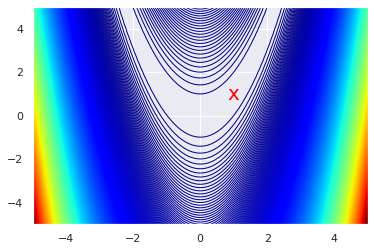

In [ ]:
# Note: the global minimum is at (1,1) in a tiny contour island
plt.contour(X, Y, Z, 1000, cmap = 'jet')
plt.text(1, 1, 'x', va='center', ha='center', color='red', fontsize=20);

**Finding non linear solutions - Multivariate **

**Example:**

$f_2: (x,y) = x^4 + 2x^2y^2 + y^4$ where $x,y \in \mathbb{R}$

$f_3: (x,y) = x^2 + y^2$ where $x,y \in \mathbb{R}$

Defining and plotting the functions


In [ ]:
def f2(x,y):
    return x**4 + 2*x**2 * y**2 + y**4

def f3(x,y):
    return x**2 + y**2


x = np.linspace(-10,10,50)
y = np.linspace(-10,10,50)
X, Y = np.meshgrid(x, y)
Z2 = f2(X, Y)
Z3 = f3(X, Y)

Text(0.5, 0.92, 'Function3')

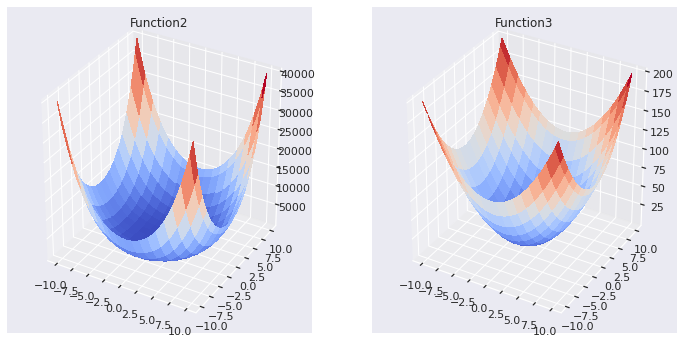

In [ ]:
%matplotlib inline
fig = plt.figure(figsize = (12,6))

#First plot: function 2
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(X,Y,Z2,rstride = 3, cstride = 3, cmap = 'coolwarm', linewidth = 0, antialiased = False )
ax.set_title("Function2")

#Second plot: function 3
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_surface(X,Y,Z3,rstride = 3, cstride = 3, cmap = 'coolwarm', linewidth = 0, antialiased = False )
ax.set_title("Function3")



Newton method - Multivariate
Generalizing the 1D approach by: **bold text**

$x_{n+1} = x_n - J^{-1} \ f(x_n)$

- $x$ and $f(x)$ are now vectors
- $J^{-1}$ is the inverse Jacobian matrix. 
- In general the Jacobian is not square and cannot be inverted, so we use the generalized inverse: $(J^TJ)^{-1}J^T$

$x_{n+1} = x_n - (J^TJ)^{-1}J^T \ f(x_n)$

**Example for f3**

$f_3: (x,y) = x^2 + y^2$ where $x,y \in \mathbb{R}$

$f'_3: (x,y) = 2x + 2y$

$ \frac{d \ f_3}{dx} = 2x $ and $ \frac{d \ f_3}{dy} = 2y $ 

$J = \left( 2x , 2y \right)$

In [ ]:
def J3(x,y):
    return np.array([2*x,2*y])

def df3dx(x,y):
    return 2*x + 2*y

# **Rosenbrock Function (Test Functions for Optimization)**

In [ ]:
import tensorflow as tf
import datetime, os
from mpl_toolkits import mplot3d
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np 
import math 

print(tf.__version__)

2.2.0


List of Optimization Algorithms<br>
https://en.m.wikipedia.org/wiki/List_of_algorithms#Optimization_algorithms

List of Test Functions for Optimization <br> https://en.m.wikipedia.org/wiki/Test_functions_for_optimization

## **Rosenbrock**

**Rosenbrock**'s function and **Himmelblau**'s function are comonly used to test optimization algorithms. We shall use them all along. You can find other functions to test [here](https://en.wikipedia.org/wiki/Test_functions_for_optimization). Source: [Omar Aflak](https://www.medium.com/@omaraflak)

https://en.wikipedia.org/wiki/Rosenbrock_function

$f(x,y) = (a - x)^2 + b * (y - x^2)^2$

It has a global minimum at $(x,y)=(a,a^2)$, where $f(x,y)=0$.

In [ ]:
def rosenbrock(X, a=1, b=100):
    x, y = X
    return (a - x)**2 + b * (y - x**2)**2

def rosenbrock_grad(X, a=1, b=100):
    x, y = X
    return np.array([
        2 * (x - a) - 4 * b * x * (y - x**2),
        2 * b * (y - x**2)
    ])

def rosenbrock_hess(X, a=1, b=100):
    x, y = X
    return np.matrix([
        [2 - 4 * b * (y - 3 * x**2), -4 * b * x],
        [-4 * b * x, 2 * b]
    ])

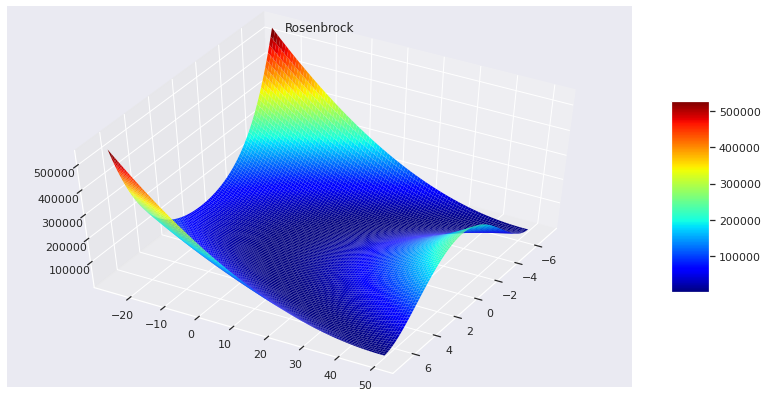

In [ ]:
x = np.linspace(-7, 7, 100)
y = np.linspace(-25, 50, 100)
X, Y = np.meshgrid(x, y)
Z = rosenbrock((X, Y))

fig = plt.figure(figsize=(14, 7))
ax = plt.axes(projection='3d')
ax.set_title('Rosenbrock')
ax.view_init(elev=50., azim=30)
rosenbrock = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='jet', edgecolor='none')
fig.colorbar(rosenbrock, shrink=0.5, aspect=5)

## **Derivative Directions**

### **Newton's direction**

$
d = - H_f^{-1}(x) \cdot \nabla_xf(x) \\
H_f(x) = \begin{bmatrix}
\frac{\partial^2 f}{\partial x_1^2} & \cdots & \frac{\partial^2 f}{\partial x_1 \partial x_n} \\
\vdots & \ddots & \vdots \\
\frac{\partial^2 f}{\partial x_n \partial x_1} & \cdots & \frac{\partial^2 f}{\partial x_n^2}
\end{bmatrix}, \quad
\nabla_xf(x) = \begin{bmatrix}
\frac{\partial f}{\partial x_1} \\
\vdots \\
\frac{\partial f}{\partial x_n}
\end{bmatrix}
$


In [ ]:
def newton(J_grad, J_hess, x_init, epsilon=1e-10, max_iterations=1000):
    x = x_init
    for i in range(max_iterations):
        x = x - np.linalg.solve(J_hess(x), J_grad(x))
        if np.linalg.norm(J_grad(x)) < epsilon:
            return x, i + 1
    return x, max_iterations

In [ ]:
# The Rosenbrock function takes 2 inputs
x_init = np.zeros(2)
x_min, it = newton(rosenbrock_grad, rosenbrock_hess, x_init)
print('x* =', x_min)
#print('Rosenbrock(x*) =', rosenbrock(x_min))
print('Grad Rosenbrock(x*) =', rosenbrock_grad(x_min))
print('Iterations =', it)

x* = [1. 1.]
Grad Rosenbrock(x*) = [0. 0.]
Iterations = 2


### **Gradient's direction**

$
d = - \nabla_xf(x) \\
\nabla_xf(x) = \begin{bmatrix}
\frac{\partial f}{\partial x_1} \\
\vdots \\
\frac{\partial f}{\partial x_n}
\end{bmatrix}
$

In [ ]:
def gradient_descent(J_grad, x_init, alpha=0.01, epsilon=1e-10, max_iterations=1000):
    x = x_init
    for i in range(max_iterations):
        x = x - alpha * J_grad(x)
        if np.linalg.norm(J_grad(x)) < epsilon:
            return x, i + 1
    return x, max_iterations

In [ ]:
# Rosenbrock takes 2 input variables that we set to 0 at first
x_init = np.zeros(2)
x_min, it = gradient_descent(rosenbrock_grad, x_init, alpha=0.002, max_iterations=5000)
print('x* =', x_min)
# print('Rosenbrock(x*) =', rosenbrock(x_min))
print('Grad Rosenbrock(x*) =', rosenbrock_grad(x_min))
print('Iterations =', it)

x* = [0.99440769 0.98882419]
Grad Rosenbrock(x*) = [-0.00225342 -0.00449072]
Iterations = 5000


### **Gradient's direction + Optimal step size**

$
d = - \alpha \nabla_xf(x) \\
\nabla_xf(x) = \begin{bmatrix}
\frac{\partial f}{\partial x_1} \\
\vdots \\
\frac{\partial f}{\partial x_n}
\end{bmatrix}, \quad \alpha \in {\Bbb R}
$

$\alpha$ is the step size, usually in the range $[0,1]$. Unlike the usual gradient descent, here we want to find the optimal $\alpha$ at every iteration. Since at every step, the update is:

$x_{k+1} = x_k - \alpha \nabla_xf(x_k)$

We want to make sure, that the chosen $\alpha$ is going to minimize as much as possible the target function $f$. Therefore, we want $\alpha$ to be such that:

$\alpha_k = \underset{\alpha}{argmin} f(x_k - \alpha \nabla_xf(x_k))$

Since at iteration $k$, $x_k$ and $\nabla_xf(x_k)$ are constants, we can define $q(\alpha)$:

$q(\alpha) = f(x_k - \alpha \nabla_xf(x_k))$

that is a function of one variable, $\alpha$. Therefore, we want to find the right $\alpha$ that will minimize $q$. That task can be solved for instance using gradient descent itself, but since we know that $/alpha$ is bounded, we are going to use another algorithm more suited for this task: Golden Section Search.

https://en.wikipedia.org/wiki/Golden-section_search

In [ ]:
def gss(f, a, b, tol=1e-7):
    phi = (np.sqrt(5) + 1) / 2
    d = b - (b - a) / phi
    c = a + (b - a) / phi

    while abs(d - c) > tol:
        if f(d) < f(c):
            b = c
        else:
            a = d

        d = b - (b - a) / phi
        c = a + (b - a) / phi

    return (a + b) / 2

def gradient_descent_optimal(J, J_grad, x_init, epsilon=1e-10, max_iterations=1000):
    x = x_init
    for i in range(max_iterations):
        q = lambda alpha: J(x - alpha * J_grad(x))
        alpha = gss(q, 0, 1)
        x = x - alpha * J_grad(x)
        if np.linalg.norm(J_grad(x)) < epsilon:
            return x, i + 1
    return x, max_iterations

In [ ]:
# The Rosenbrock function takes 2 inputs
x_init = np.zeros(2)
# x_min, it = gradient_descent_optimal(rosenbrock, rosenbrock_grad, x_init, max_iterations=3000)
print('x* =', x_min)
# print('Rosenbrock(x*) =', rosenbrock(x_min))
print('Grad Rosenbrock(x*) =', rosenbrock_grad(x_min))
print('Iterations =', it)

x* = [3. 2.]
Grad Rosenbrock(x*) = [ 8403.99999998 -1400.        ]
Iterations = 93


# **Himmelblau Function (Test Functions for Optimization)**

In [ ]:
import tensorflow as tf
import datetime, os
from mpl_toolkits import mplot3d
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np 
import math 

print(tf.__version__)

2.2.0


List of Optimization Algorithms<br>
https://en.m.wikipedia.org/wiki/List_of_algorithms#Optimization_algorithms

List of Test Functions for Optimization <br> https://en.m.wikipedia.org/wiki/Test_functions_for_optimization

## **Himmelblau**

https://en.wikipedia.org/wiki/Himmelblau%27s_function

$f(x,y) = (x^2 + y - 11)^2 + (x + y^2 - 7)^2$

The Himmelblau's function has one local maximum at $(x,y) = (-0.270845, -0.923039)$ where $f(x,y)=181.617$, and four identical local minima:

$
f(3.0,2.0)=0 \\
f(-2.805118,3.131312)=0 \\
f(-3.779310,-3.283186)=0 \\ 
f(3.584428,-1.848126)=0
$

In [ ]:
def himmelblau(X):
    x, y = X
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2

def himmelblau_grad(X):
    x, y = X
    return np.array([
        4 * x * (x**2 + y - 11) + 2 * (x + y**2 - 7),
        2 * (x**2 + y - 11) + 4 * y * (x + y**2 - 7)
    ])

def himmelblau_hess(X):
    x, y = X
    return np.array([
        [2 - 400 * (y - 3 * x**2), -400 * x],
        [-400 * x, 200]
    ])

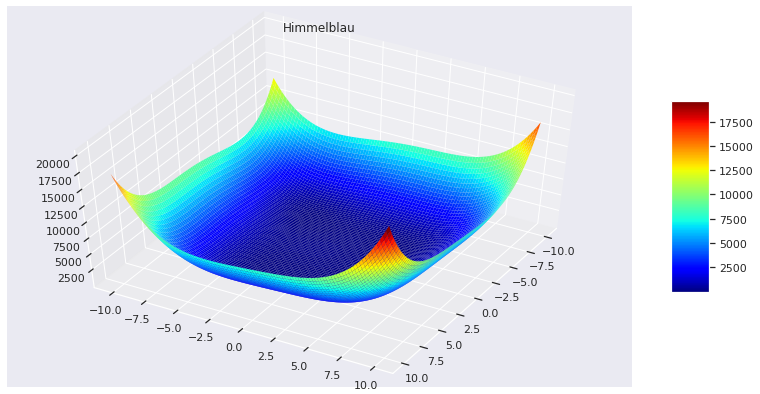

In [ ]:
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
X, Y = np.meshgrid(x, y)
Z = himmelblau((X, Y))

fig = plt.figure(figsize=(14, 7))
ax = plt.axes(projection='3d')
ax.set_title('Himmelblau')
ax.view_init(elev=50., azim=30)
himmelblau = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='jet', edgecolor='none')
fig.colorbar(himmelblau, shrink=0.5, aspect=5)

## **Derivative Directions**

### **Newton's direction**

$
d = - H_f^{-1}(x) \cdot \nabla_xf(x) \\
H_f(x) = \begin{bmatrix}
\frac{\partial^2 f}{\partial x_1^2} & \cdots & \frac{\partial^2 f}{\partial x_1 \partial x_n} \\
\vdots & \ddots & \vdots \\
\frac{\partial^2 f}{\partial x_n \partial x_1} & \cdots & \frac{\partial^2 f}{\partial x_n^2}
\end{bmatrix}, \quad
\nabla_xf(x) = \begin{bmatrix}
\frac{\partial f}{\partial x_1} \\
\vdots \\
\frac{\partial f}{\partial x_n}
\end{bmatrix}
$


In [ ]:
def newton(J_grad, J_hess, x_init, epsilon=1e-10, max_iterations=1000):
    x = x_init
    for i in range(max_iterations):
        x = x - np.linalg.solve(J_hess(x), J_grad(x))
        if np.linalg.norm(J_grad(x)) < epsilon:
            return x, i + 1
    return x, max_iterations

In [ ]:
# The Himmelblau function takes 2 inputs

x_init = np.zeros(2)
x_min, it = newton(himmelblau_grad, himmelblau_hess, x_init, max_iterations=2000)
print('x* =', x_min)
#print('Himmelblau(x*) =', himmelblau(x_min))
print('Grad Himmelblau(x*) =', himmelblau_grad(x_min))
print('Iterations =', it)

x* = [ 3.58445593 -1.84814172]
Grad Himmelblau(x*) = [ 0.00278585 -0.00025377]
Iterations = 2000


### **Gradient's direction**

$
d = - \nabla_xf(x) \\
\nabla_xf(x) = \begin{bmatrix}
\frac{\partial f}{\partial x_1} \\
\vdots \\
\frac{\partial f}{\partial x_n}
\end{bmatrix}
$

In [ ]:
def gradient_descent(J_grad, x_init, alpha=0.01, epsilon=1e-10, max_iterations=1000):
    x = x_init
    for i in range(max_iterations):
        x = x - alpha * J_grad(x)
        if np.linalg.norm(J_grad(x)) < epsilon:
            return x, i + 1
    return x, max_iterations

In [ ]:
# The Himmelblau function takes 2 inputs
x_init = np.zeros(2)
x_min, it = gradient_descent(himmelblau_grad, x_init)
print('x* =', x_min)
# print('Himmelblau(x*) =', himmelblau(x_min))
print('Grad Himmelblau(x*) =', himmelblau_grad(x_min))
print('Iterations =', it)

x* = [3. 2.]
Grad Himmelblau(x*) = [-3.28554961e-11  7.93143329e-11]
Iterations = 93


### **Gradient's direction + Optimal step size**

$
d = - \alpha \nabla_xf(x) \\
\nabla_xf(x) = \begin{bmatrix}
\frac{\partial f}{\partial x_1} \\
\vdots \\
\frac{\partial f}{\partial x_n}
\end{bmatrix}, \quad \alpha \in {\Bbb R}
$

$\alpha$ is the step size, usually in the range $[0,1]$. Unlike the usual gradient descent, here we want to find the optimal $\alpha$ at every iteration. Since at every step, the update is:

$x_{k+1} = x_k - \alpha \nabla_xf(x_k)$

We want to make sure, that the chosen $\alpha$ is going to minimize as much as possible the target function $f$. Therefore, we want $\alpha$ to be such that:

$\alpha_k = \underset{\alpha}{argmin} f(x_k - \alpha \nabla_xf(x_k))$

Since at iteration $k$, $x_k$ and $\nabla_xf(x_k)$ are constants, we can define $q(\alpha)$:

$q(\alpha) = f(x_k - \alpha \nabla_xf(x_k))$

that is a function of one variable, $\alpha$. Therefore, we want to find the right $\alpha$ that will minimize $q$. That task can be solved for instance using gradient descent itself, but since we know that $/alpha$ is bounded, we are going to use another algorithm more suited for this task: Golden Section Search.

https://en.wikipedia.org/wiki/Golden-section_search

In [ ]:
def gss(f, a, b, tol=1e-7):
    phi = (np.sqrt(5) + 1) / 2
    d = b - (b - a) / phi
    c = a + (b - a) / phi

    while abs(d - c) > tol:
        if f(d) < f(c):
            b = c
        else:
            a = d

        d = b - (b - a) / phi
        c = a + (b - a) / phi

    return (a + b) / 2

def gradient_descent_optimal(J, J_grad, x_init, epsilon=1e-10, max_iterations=1000):
    x = x_init
    for i in range(max_iterations):
        q = lambda alpha: J(x - alpha * J_grad(x))
        alpha = gss(q, 0, 1)
        x = x - alpha * J_grad(x)
        if np.linalg.norm(J_grad(x)) < epsilon:
            return x, i + 1
    return x, max_iterations

In [ ]:
# The Himmelblau function takes 2 inputs
x_init = np.zeros(2)
# x_min, it = gradient_descent_optimal(himmelblau, himmelblau_grad, x_init)
print('x* =', x_min)
# print('Himmelblau(x*) =', himmelblau(x_min))
print('Grad Himmelblau(x*) =', himmelblau_grad(x_min))
print('Iterations =', it)

x* = [3. 2.]
Grad Himmelblau(x*) = [-3.28554961e-11  7.93143329e-11]
Iterations = 93


# **Easom Function (Test Functions for Optimization)**

In [ ]:
import tensorflow as tf
import datetime, os
from mpl_toolkits import mplot3d
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np 
import math 

print(tf.__version__)

2.2.0


List of Optimization Algorithms<br>
https://en.m.wikipedia.org/wiki/List_of_algorithms#Optimization_algorithms

List of Test Functions for Optimization <br> https://en.m.wikipedia.org/wiki/Test_functions_for_optimization

## **Easom**

$f(x,y) = -cos(x)cos(y)exp(-(x-\pi)^2 - (y-\pi)^2)$

$f$ has a global minimum in $(x,y) = (\pi,\pi)$, where $f(\pi, \pi) = -1$.

In [ ]:
def easom(X):
    x, y = X
    return -np.cos(x) * np.cos(y) * np.exp(-(x - np.pi)**2 -(y - np.pi)**2)

def easom_grad(X):
    x, y = X
    return np.array([
        np.cos(y) * np.exp(-(x - np.pi)**2 -(y - np.pi)**2) * (np.sin(x) + 2 * np.cos(x)),
        np.cos(x) * np.exp(-(y - np.pi)**2 -(x - np.pi)**2) * (np.sin(y) + 2 * np.cos(y))
    ])

# still have to add the hessian

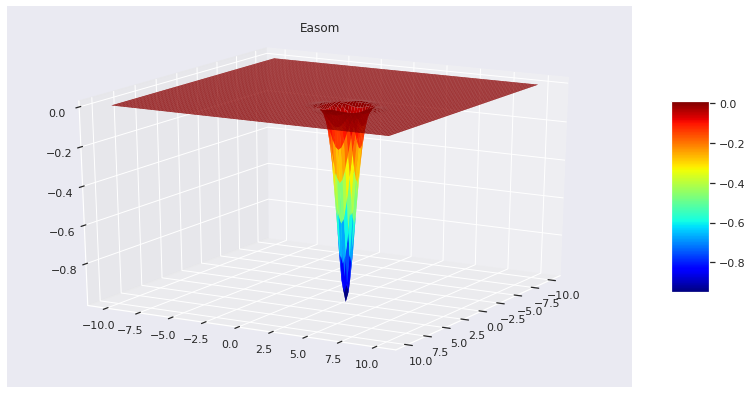

In [ ]:
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
X, Y = np.meshgrid(x, y)
Z = easom((X, Y))

fig = plt.figure(figsize=(14, 7))
ax = plt.axes(projection='3d')
ax.set_title('Easom')
ax.view_init(elev=20., azim=30)
s = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='jet', edgecolor='none')
fig.colorbar(s, shrink=0.5, aspect=5)

# **Taylor Series Expansion**

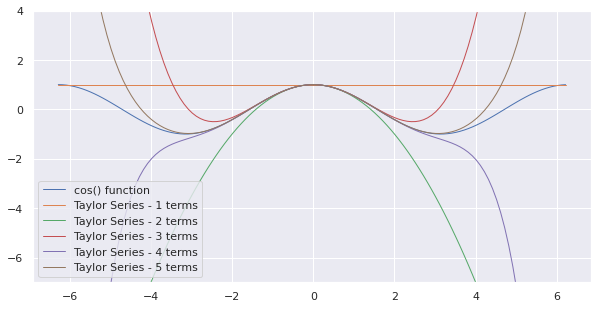

In [ ]:
#@title

import math
import numpy as np
import matplotlib.pyplot as plt
import pandas.util.testing as tm
import seaborn as sns
# if using a Jupyter notebook, include:
%matplotlib inline

sns.set(rc={'figure.figsize':(10, 5), "lines.linewidth": 1.0})

def func_cos(x, n):
    cos_approx = 0
    for i in range(n):
        coef = (-1)**i
        num = x**(2*i)
        denom = math.factorial(2*i)
        cos_approx += ( coef ) * ( (num)/(denom) )
    
    return cos_approx

angles = np.arange(-2*np.pi,2*np.pi,0.1)
p_cos = np.cos(angles)

fig, ax = plt.subplots()
ax.plot(angles,p_cos)

# add lines for between 1 and 6 terms in the Taylor Series
for i in range(1,6):
    t_cos = [func_cos(angle,i) for angle in angles]
    ax.plot(angles,t_cos)

ax.set_ylim([-7,4])

# set up legend
legend_lst = ['cos() function']
for i in range(1,6):
    legend_lst.append(f'Taylor Series - {i} terms')
ax.legend(legend_lst, loc=3)

plt.show()

The Taylor expansion is one of the most beautiful ideas in mathematics. The intuition is simple: most functions are smooth over ranges we’re interested in. And polynomials are also smooth. So for every smooth function, we should be able to write down a polynomial that approximates it pretty well.

And in fact, if our polynomial contains enough terms it will exactly equal the original function. Since polynomials are easier to work with than almost any other kind of function, this usually turns hard problems into easy ones. The Taylor formula is the key. It gives us an equation for the polynomial expansion for every smooth function f.

**Approach**

* In order to turn a function into a series of power terms we want to have this expansion:

* f(x) = c<sub>0</sub> + c<sub>1</sub>(x-a) + c<sub>2</sub>(x-a)<sup>2</sup> + c<sub>3</sub>(x-a)<sup>3</sup> + ...

* Then we choose a value "a", and work out the values c0 , c1 , c2 , ... etc, which it is done using derivatives (so we must know the derivative of our function). Note: A **Maclaurin Series** is a Taylor Series where a=0.
* We just need to calculate the first n derivatives of f, evaluate them at c, divide each one by n!, and sum up these terms. The result will be a good approximation to our original function. The more terms we add on, the more accurate the polynomial approximation will be.

**Summary** 

In mathematical analysis Taylor series is used to turn or represent a smooth non-polynomial function (like e<sup>x</sup>) into a series of power terms around a location, which is the limit of the Taylor polynomials. This series development is called the Taylor development.

* **What?** (Definition): A Taylor Series is an expansion of some function into an infinite sum of polynomial terms, where each term has a larger exponent like x, x<sup>2</sup>, x<sup>3</sup>, etc.
* **How?** (Approach): Take non-polynomial function (for example: e<sup>x</sup>) and find approximate polynomial. We can use the first few terms of a Taylor Series to get an approximate value for a function. Note: The key thing is to know the derivatives of your function f(x). Derivative of Polynome = Derivative of Function
* **Why?** (Objective): Simplifies calculation of values, computing its derivatives or integral.

**Additional Ressources**

* [Studyflix - Taylorreihen](https://studyflix.de/mathematik/taylorreihen-910)
* ['Taylor Series on Wikipedia'](https://de.m.wikipedia.org/wiki/Taylorreihe)
* ['Maths is Fun'](https://www.mathsisfun.com/algebra/taylor-series.html)
* ['Easy Way to Remember the Taylor Series Expansion'](https://medium.com/@andrew.chamberlain/an-easy-way-to-remember-the-taylor-series-expansion-a7c3f9101063)

**Code Taylor Series**

*The following code examples are taken from ['Python for Undergraduate Engineers'](https://pythonforundergradengineers.com/creating-taylor-series-functions-with-python.html)*

A Taylor Series is an infinite series of mathematical terms that when summed together approximate a mathematical function. A Taylor Series can be used to approximate e<sup>x</sup>, and cosine.

An example of a Taylor Series that approximates e<sup>x</sup> is below.

> $e^{x} \approx \sum_{n=0}^{\infty} \frac{x^{n}}{n !} \approx 1+x+\frac{x^{2}}{2 !}+\frac{x^{3}}{3 !}+\frac{x^{4}}{4 !}+\ldots$

We can see that each term in the Taylor Series expansion is dependent on that term's place in the series. Below is a chart that shows each term of the Taylor Series in a row.

* Term: x<sup>0</sup>/0! - Code: x**0/math.factorial(0)
* Term: x<sup>1</sup>/1! - Code: x**1/math.factorial(1)
* ...


**Code the Taylor Series by writing out each term individually**

We can combine these terms in a line of Python code to estimate e<sup>2</sup>
. The code below calculates the sum of the first five terms of the Taylor Series expansion of e<sup>x</sup>
, where x=2.

$e^{x} \approx \sum_{n=0}^{\infty} \frac{x^{n}}{n !} \approx 1+x+\frac{x^{2}}{2 !}+\frac{x^{3}}{3 !}+\frac{x^{4}}{4 !}+\ldots$

We can see that each term in the Taylor Series expansion is dependent on that term's place in the series. 

In [ ]:
import math

x = 2
e_to_2 = x**0/math.factorial(0) + x**1/math.factorial(1) + x**2/math.factorial(2) + x**3/math.factorial(3) + x**4/math.factorial(4)
print(e_to_2)

7.0


Our Taylor Series approximation of e<sup>2</sup>
 was calculated as 7.0. Let's compare our Taylor Series approximation to Python's math.exp() function. Python's math.exp() function raises e
 to any power. In our case, we want to use math.exp(2) because we want to calculate e2
.

In [ ]:
print(math.exp(2))

7.38905609893065


**Use a for loop to calculate a Taylor Series**

If we want to get closer to the value of e<sup>x</sup>
, we need to add more terms to our Taylor Series. The problem is coding each individual term is time-consuming and repetitive. Instead of coding each term individually, we can use a for loop. A for loop is a repetition structure in Python that runs a section of code a specified number of times. The syntax for coding a for loop in Python using the range() function is below:

In [ ]:
for <var> in range(<num>):
    <code>

Where 'var' is any valid Python variable name and 'num' is an integer to determines how many times the 'code' in the loop runs.

We can recreate our approximation of e<sup>2</sup>
 with 5 terms using a for loop. Note we need to set the variable e_to_2 to 0 before the loop starts. The mathematical operator += in the line e_to_2 += x**i/math.factorial(i) is equivalent to e_to_2 = e_to_2 + x**i/math.factorial(i).

In [ ]:
import math

x = 2
e_to_2 = 0
for i in range(5):
    e_to_2 += x**i/math.factorial(i)
    
print(e_to_2)

7.0


The result 7.0 is the same as the result we calculated when we wrote out each term of the Taylor Series individually.

An advantage of using a for loop is that we can easily increase the number of terms. If we increase the number of times the for loop runs, we increase the number of terms in the Taylor Series expansion. Let's try 10 terms. Note how the line for i in range(10): now includes 10 passed to the range() function.

In [ ]:
import math

x = 2
e_to_2 = 0
for i in range(10):
    e_to_2 += x**i/math.factorial(i)
    
print(e_to_2)

7.3887125220458545


**Refactor the for loop into a function**

Next, let's refactor the code above that contained a for loop (which calculated e2
) into a function that can compute e
 raised to any power estimated with any number of terms in the Taylor Series. The general syntax to define a function in Python is below.

In [ ]:
def <func name>(<arg 1>, <arg 2>, ...):
    <code>
    return <output>

Where def is the Python keyword that defines a function, 'func name' is a valid Python variable name, and 'arg 1', 'arg 2' are the input arguments passed to the function. 'code' that runs when the function is called must be indented (the standard indentation is 4 spaces). The keyword return denotes the 'output' of the function.

In [ ]:
import math

def func_e_to_2(n):
    x = 2
    e_to_2 = 0
    for i in range(n):
        e_to_2 += x**i/math.factorial(i)
    
    return e_to_2

If we call our function func_e_to_2() with the input argument 10, the result is the same as when we ran the for loop 10 times.

In [ ]:
out = func_e_to_2(10)
print(out)

7.3887125220458545


**Generalize Function**

We can make our function more general by setting x (the number that e
gets raised to) as an input argument. Note how now there are two input arguments in the function definition (x, n). x is the number e
 is raised to, and n is the number of terms in the Taylor Series (which is the number of times the for loop runs on the inside of the function definition).

In [ ]:
import math

def func_e(x, n):
    e_approx = 0
    for i in range(n):
        e_approx += x**i/math.factorial(i)
    
    return e_approx

Let's calculate e<sup>2</sup> using 10 terms with our new func_e() function.

In [ ]:
out = func_e(2,10)
print(out)

7.3887125220458545


An advantage to writing our Taylor Series expansion in a function is that now the Taylor Series approximation calculation is reusable and can be called in one line of code. For instance, we can estimate the value of e5
with 10 terms, by calling our func_e() function with the input arguments (5,10).

In [ ]:
out = func_e(5,10)
print(out)

143.68945656966488


The result is 143.68945.... Let's see how close this value is to Python's exp() function when we make the same calculation e<sup>5</sup>
.

In [ ]:
out = math.exp(5)
print(out)

148.4131591025766


**Use a for loop to calculate the difference between the Taylor Series expansion and Python's exp() function**

Now let's use a for loop to calculate the difference between the Taylor Series expansion as calculated by our func_e() function compared to Python's exp() function. We'll calculate the difference between the two functions when we use between 1 and 10 terms in the Taylor Series expansion.

The code below uses f-strings, which is a Python syntax for inserting the value of a variable in a string. The general syntax for an f-string in Python is below.

In [ ]:
f'string statment {<var>}'

Where f denotes the beginning of an f-string, the f-string is surrounded by quotes ' ', and the variable 'var' is enclosed in curly braces { }. The value of 'var' will be printed out without the curly braces.

In [ ]:
import math

x = 5
for i in range(1,11):
    e_approx = func_e(x,i)
    e_exp = math.exp(x)
    e_error = abs(e_approx - e_exp)
    print(f'{i} terms: Taylor Series approx= {e_approx}, exp calc= {e_exp}, error = {e_error}')

1 terms: Taylor Series approx= 1.0, exp calc= 148.4131591025766, error = 147.4131591025766
2 terms: Taylor Series approx= 6.0, exp calc= 148.4131591025766, error = 142.4131591025766
3 terms: Taylor Series approx= 18.5, exp calc= 148.4131591025766, error = 129.9131591025766
4 terms: Taylor Series approx= 39.33333333333333, exp calc= 148.4131591025766, error = 109.07982576924327
5 terms: Taylor Series approx= 65.375, exp calc= 148.4131591025766, error = 83.0381591025766
6 terms: Taylor Series approx= 91.41666666666667, exp calc= 148.4131591025766, error = 56.99649243590993
7 terms: Taylor Series approx= 113.11805555555556, exp calc= 148.4131591025766, error = 35.29510354702104
8 terms: Taylor Series approx= 128.61904761904762, exp calc= 148.4131591025766, error = 19.79411148352898
9 terms: Taylor Series approx= 138.30716765873015, exp calc= 148.4131591025766, error = 10.105991443846449
10 terms: Taylor Series approx= 143.68945656966488, exp calc= 148.4131591025766, error = 4.723702532911

Note how the error decreases as we add terms to the Taylor Series. When the Taylor Series only has 1 term, the error is 147.41.... When 10 terms are used in the Taylor Series, the error goes down to 4.7237....

**Use a break statement to exit a for loop early**

How many terms would it take to produce an error of less than 1? We can use a break statement to drop out of the for loop when the error is less than 1. The code below calculates how many terms are needed in the Taylor Series, when e<sup>5</sup> is calculated, to keep the error less than 1.

In [ ]:
import math

x = 5
for i in range(1,20):
    e_approx = func_e(x,i)
    e_exp = math.exp(x)
    e_error = abs(e_approx - e_exp)
    if e_error < 1:
        break
        
print(f'{i} terms: Taylor Series approx= {e_approx}, exp calc= {e_exp}, error = {e_error}')

12 terms: Taylor Series approx= 147.60384850489015, exp calc= 148.4131591025766, error = 0.8093105976864479


The output shows that it takes 12 terms in the Taylor Series to drop the error below 1.

**Create a function to estimate the value of cos(x) using a Taylor Series**

Next, let's calculate the value of the cosine function using a Taylor Series. The Taylor Series expansion for cos(x)
 is below.

$\cos (x) \approx \sum_{n=0}^{\infty}(-1)^{n} \frac{x^{2 n}}{(2 n) !} \approx 1-\frac{x^{2}}{2 !}+\frac{x^{4}}{4 !}-\frac{x^{6}}{6 !}+\frac{x^{8}}{8 !}-\frac{x^{10}}{10 !}+\ldots$



We can code this formula into a function that contains a for loop. Note the variable x is the value we are trying to find the cosine of, the variable n is the number of terms in the Taylor Series, and the variable i is the loop index which is also the Taylor Series term number. We are using a separate variable for the coefficient coef which is equal to (−1)<sup>i</sup>
, the numerator num which is equal to x<sup>2i</sup>
 and the denominator denom which is equal to (2i!)
. Breaking the Taylor Series formula into three parts can cut down on coding errors.

In [ ]:
import math

def func_cos(x, n):
    cos_approx = 0
    for i in range(n):
        coef = (-1)**i
        num = x**(2*i)
        denom = math.factorial(2*i)
        cos_approx += ( coef ) * ( (num)/(denom) )
    
    return cos_approx

Let's use our func_cos() function to estimate the cosine of 45 degrees. Note that func_cos() function computes the cosine of an angle in radians. If we want to calculate the cosine of 45 degrees using our function, we first have to convert 45 degrees into radians. Luckily, Python's math module has a function called radians() that makes the angle conversion early.

In [ ]:
angle_rad = (math.radians(45))
out = func_cos(angle_rad,5)
print(out)

0.7071068056832942


Using our func_cos() function and 5 terms in the Taylor Series approximation, we estimate the cosine of 45 degrees is 0.707106805.... Let's check our func_cos() function compared to Python's cos() function from the math module.

In [ ]:
out = math.cos(angle_rad)
print(out)

0.7071067811865476


Using Python's cos() function, the cosine of 45 degrees returns 0.707106781... This value is very close to the approximation calculated using our func_cos() function.

**Build a plot to compare the Taylor Series approximation to Python's cos() function**

In the last part of this post, we are going to build a plot that shows how the Taylor Series approximation calculated by our func_cos() function compares to Python's cos() function.

The idea is to make a plot that has one line for Python's cos() function and lines for the Taylor Series approximation based on different numbers of terms.

For instance, if we use 3 terms in the Taylor Series approximation, our plot has two lines. One line for Python's cos() function and one line for our func_cos() function with three terms in the Taylor series approximation. We'll calculate the cosine using both functions for angles between −2π
radians and 2π
 radians.

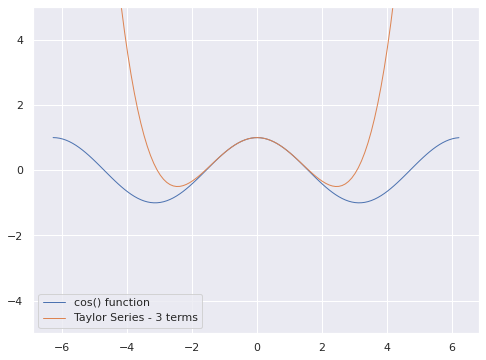

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# if using a Jupyter notebook, include:
%matplotlib inline

sns.set(rc={'figure.figsize':(8, 6), "lines.linewidth": 1.0})

angles = np.arange(-2*np.pi,2*np.pi,0.1)
p_cos = np.cos(angles)
t_cos = [func_cos(angle,3) for angle in angles]

fig, ax = plt.subplots()
ax.plot(angles,p_cos)
ax.plot(angles,t_cos)
ax.set_ylim([-5,5])
ax.legend(['cos() function','Taylor Series - 3 terms'])

plt.show()

We can use a for loop to see how much better adding additional terms to our Taylor Series approximation compares to Python's cos() function.

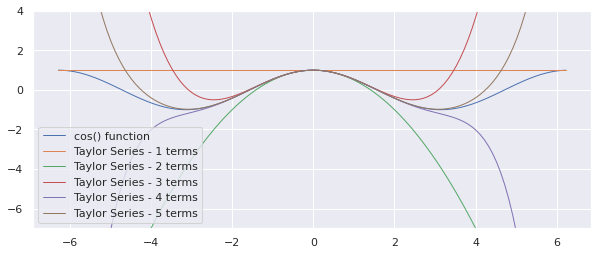

In [ ]:
#@title
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# if using a Jupyter notebook, include:
%matplotlib inline

sns.set(rc={'figure.figsize':(10, 4), "lines.linewidth": 1.0})

angles = np.arange(-2*np.pi,2*np.pi,0.1)
p_cos = np.cos(angles)

fig, ax = plt.subplots()
ax.plot(angles,p_cos)

# add lines for between 1 and 6 terms in the Taylor Series
for i in range(1,6):
    t_cos = [func_cos(angle,i) for angle in angles]
    ax.plot(angles,t_cos)

ax.set_ylim([-7,4])

# set up legend
legend_lst = ['cos() function']
for i in range(1,6):
    legend_lst.append(f'Taylor Series - {i} terms')
ax.legend(legend_lst, loc=3)

plt.show()

We see the Taylor Series with 5 terms (the brown line) comes closest to approximating Python's cos() function. The Taylor Series with 5 terms is a good approximation of the cosine of angles between about −π
 and π
radians. The Taylor Series with 5 terms is a worse approximation for angles less than −π
 or greater than π
. As the angle gets further away from zero radians, the estimate of the cosine using a Taylor Series gets worse and worse.